Trains a grammar encoder to predict meta-scene-tree production params (grammars) on the 2D box grammar.

In [1]:
%load_ext autoreload
%autoreload 2    
# Autoreload isn't working for the ssg stuff,
# unclear why, I think it has too many layers of imports.

from collections import namedtuple
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time
from functools import reduce 
import operator
def prod(iterable):
    return reduce(operator.mul, iterable, 1)

import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.contrib.autoname import scope

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.torch_utils import *
from spatial_scene_grammars.neural_grammar_proposal import *

from spatial_scene_grammars_examples.planar_box_stacks_complex.grammar import *

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/ipykernel_launcher.py:23: _DrakeImportWarning: 
You may have already (directly or indirectly) imported `torch` which uses
`RTLD_GLOBAL`. Using `RTLD_GLOBAL` may cause symbol collisions which manifest
themselves in bugs like "free(): invalid pointer". Please consider importing
`pydrake` (and related C++-wrapped libraries like `cv2`, `open3d`, etc.)
*before* importing `torch`. For more details, see:
https://github.com/pytorch/pytorch/issues/3059#issuecomment-534676459

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Unconditional grammar outputs look like this:

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


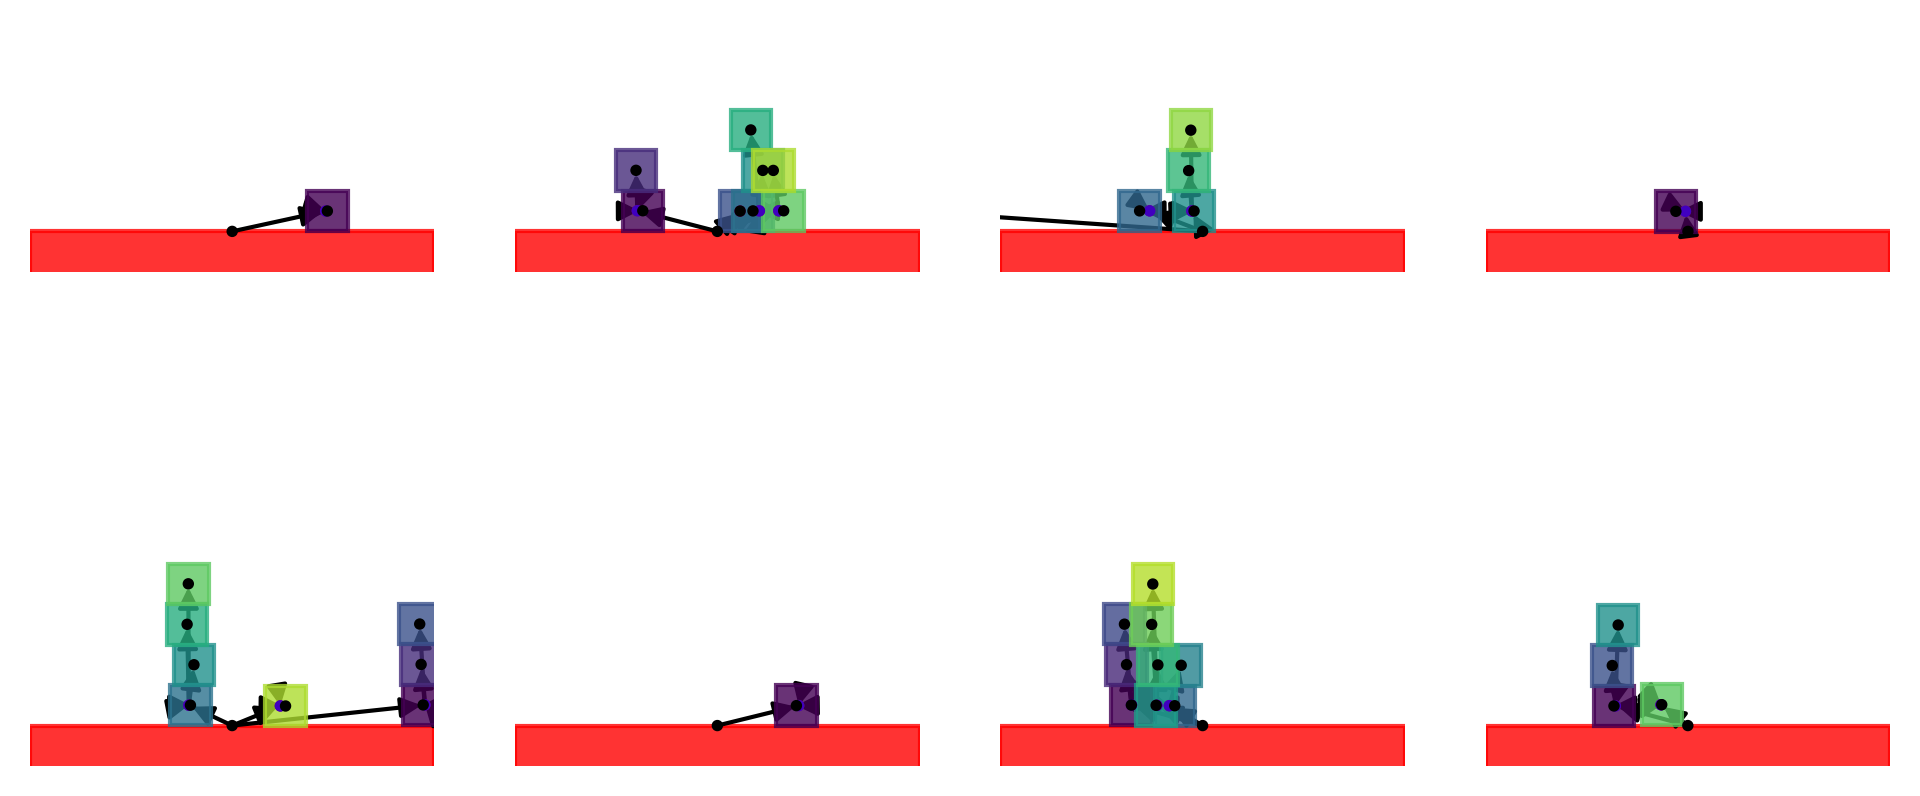

In [2]:
root_inst_dict = {"xy": dist.Normal(torch.tensor([0., 0.]), torch.tensor([0.001, 0.001]))}
grammar = SceneGrammar(Ground, root_inst_dict)
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        tree = grammar()
        draw_boxes(tree, fig=fig, ax=ax, block=False)
plt.show()

With an additional nonpenetration constraint, we rejection sample and no longer get penetrating configurations:

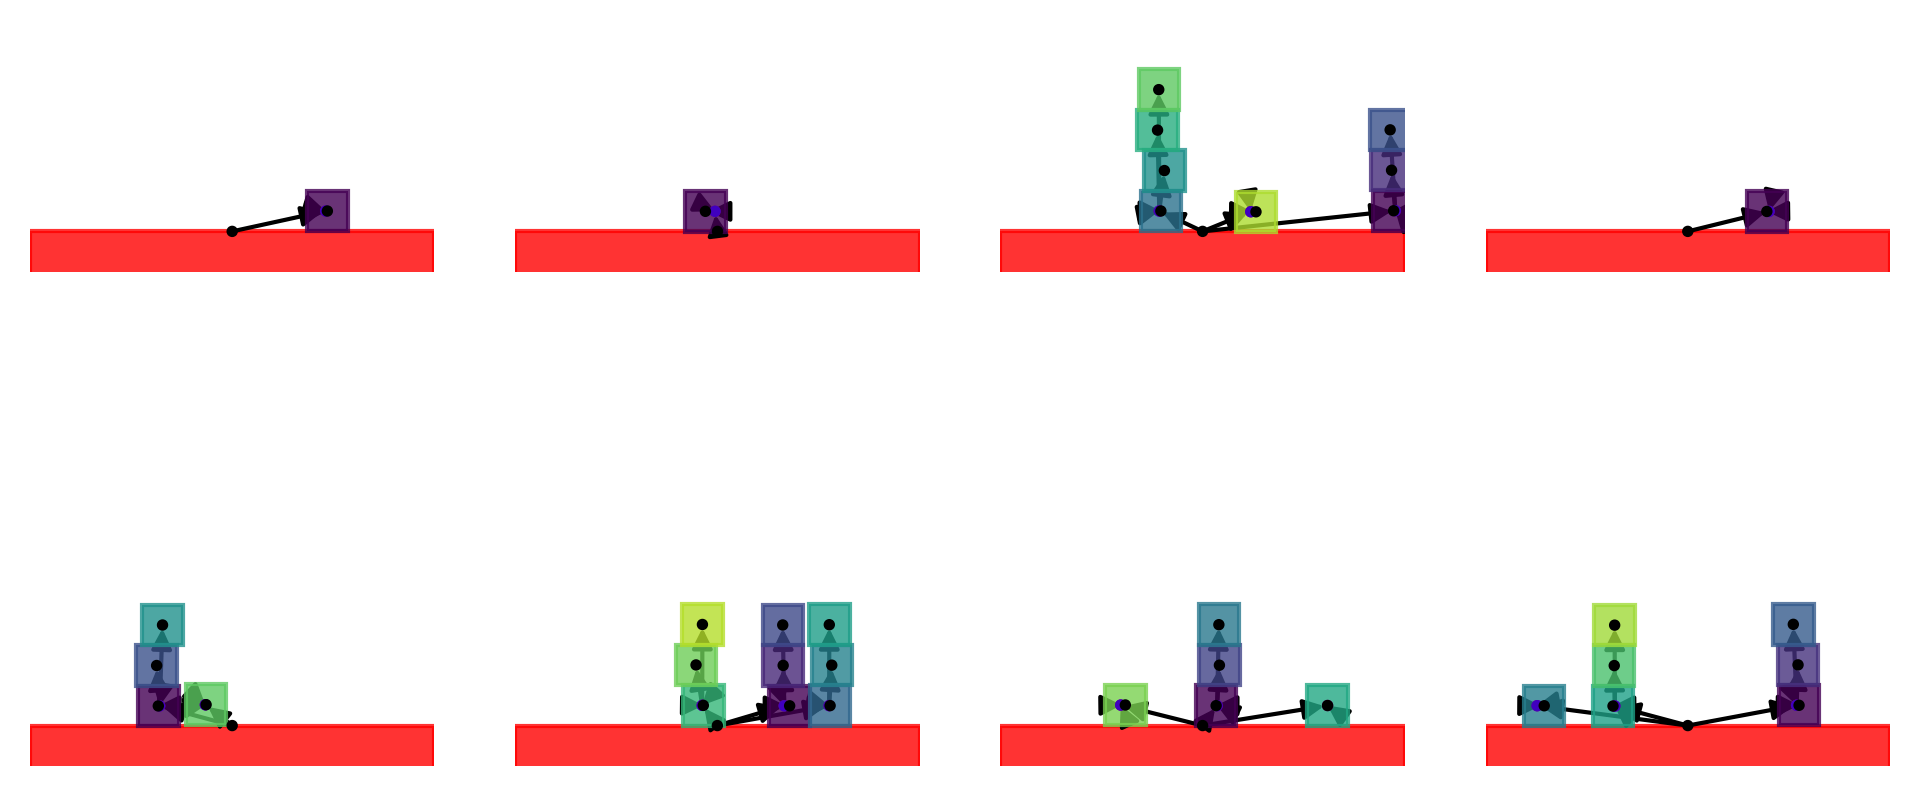

In [3]:
plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
observed_full_trees = []
for i in range(N_width):
    for j in range(N_height):
        ax = plt.subplot(N_height, N_width, i*N_height + j + 1)
        scene_trees, success = sample_tree_from_grammar_with_constraints(
            grammar,
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
        if not success:
            print("WARNING: SAMPLING UNSUCCESSFUL")
        draw_boxes(scene_trees[0], fig=fig, ax=ax, block=False)
        observed_full_trees.append(scene_trees[0])
plt.show()

In [4]:
trace = pyro.poutine.trace(grammar.forward).get_trace()
print(trace.nodes.keys())

odict_keys(['_INPUT', 'Ground_26_sample_derived/xy', 'Ground_26_choose_children/sample_children_inclusion', 'Group_66_sample_derived/xy', 'Group_66_choose_children/sample_children_inclusion', 'Stack_59_sample_derived/xy', 'Stack_59_choose_children/sample_children_inclusion', 'Box_130_sample_derived/xy', 'Box_131_sample_derived/xy', '_RETURN'])


The "meta" ("super"? "Hyper", as in hypergraph? still deciding terminology) scene tree is a tree containing all scene trees in the language -- any generated tree is a subtree of this tree. Here it is for this language. I'm wondering at the moment if it's the right structure to make reasoning about inference over the space of scene trees easier.


(341.11344999999994, 978.91655, -37.33605, 600.34605)

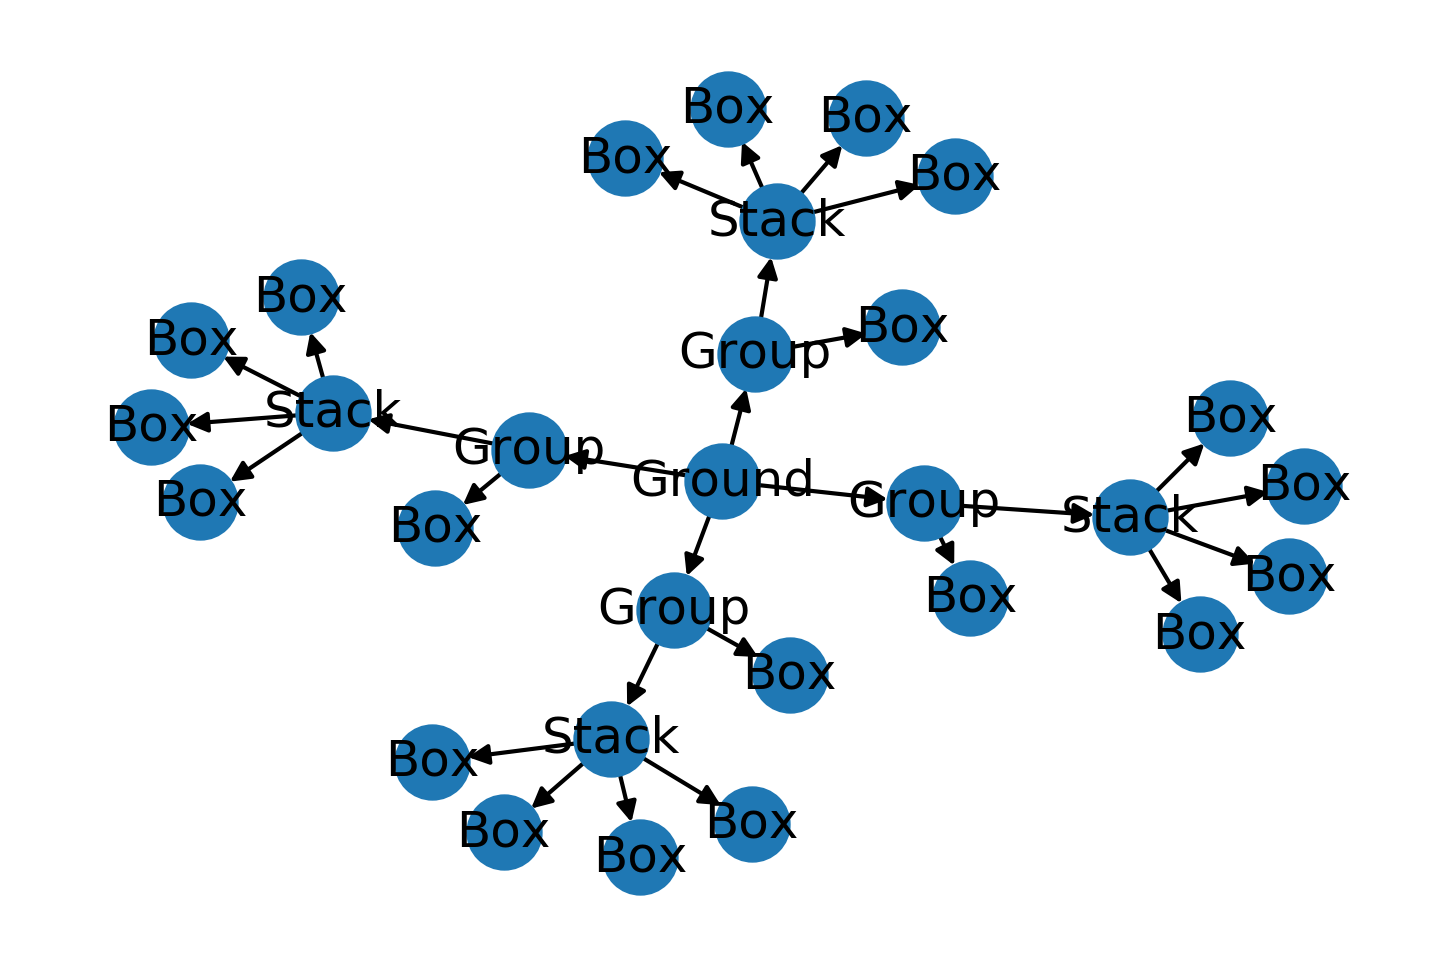

In [5]:
from networkx.drawing.nx_agraph import graphviz_layout
plt.figure(dpi=300)
meta_tree = SceneGrammar.make_super_scene_tree(Ground)
ordering = nx.dfs_postorder_nodes(meta_tree, source=get_tree_root(meta_tree))
index_by_node = {node: k for (k, node) in enumerate(ordering)}
nx.draw_networkx(
    meta_tree,
    pos = graphviz_layout(meta_tree),
    labels={node: node.__class__.__name__ for node in meta_tree}
)
plt.axis("off")

So let's say we're given an observed set of boxes, and we'd like to think about what trees could have generated that observed set. There are two classes of strategy I'm thinking about:

1) "Top down" strategies (that try to grow trees from the root to meet the observed node set) might work, but will face scaling difficulties, and *precisely* meeting the observed nodes (and satisfying constraints) is going to be pretty tough.
2) "Bottom-up" strategies (that start from the observed node set, and parse out trees that satisfy the grammar and constraints) are more likely to be able to satisfy constraints, but they're more complex to write and turn into engines for inference, as they involve lots of ad-hoc construction.

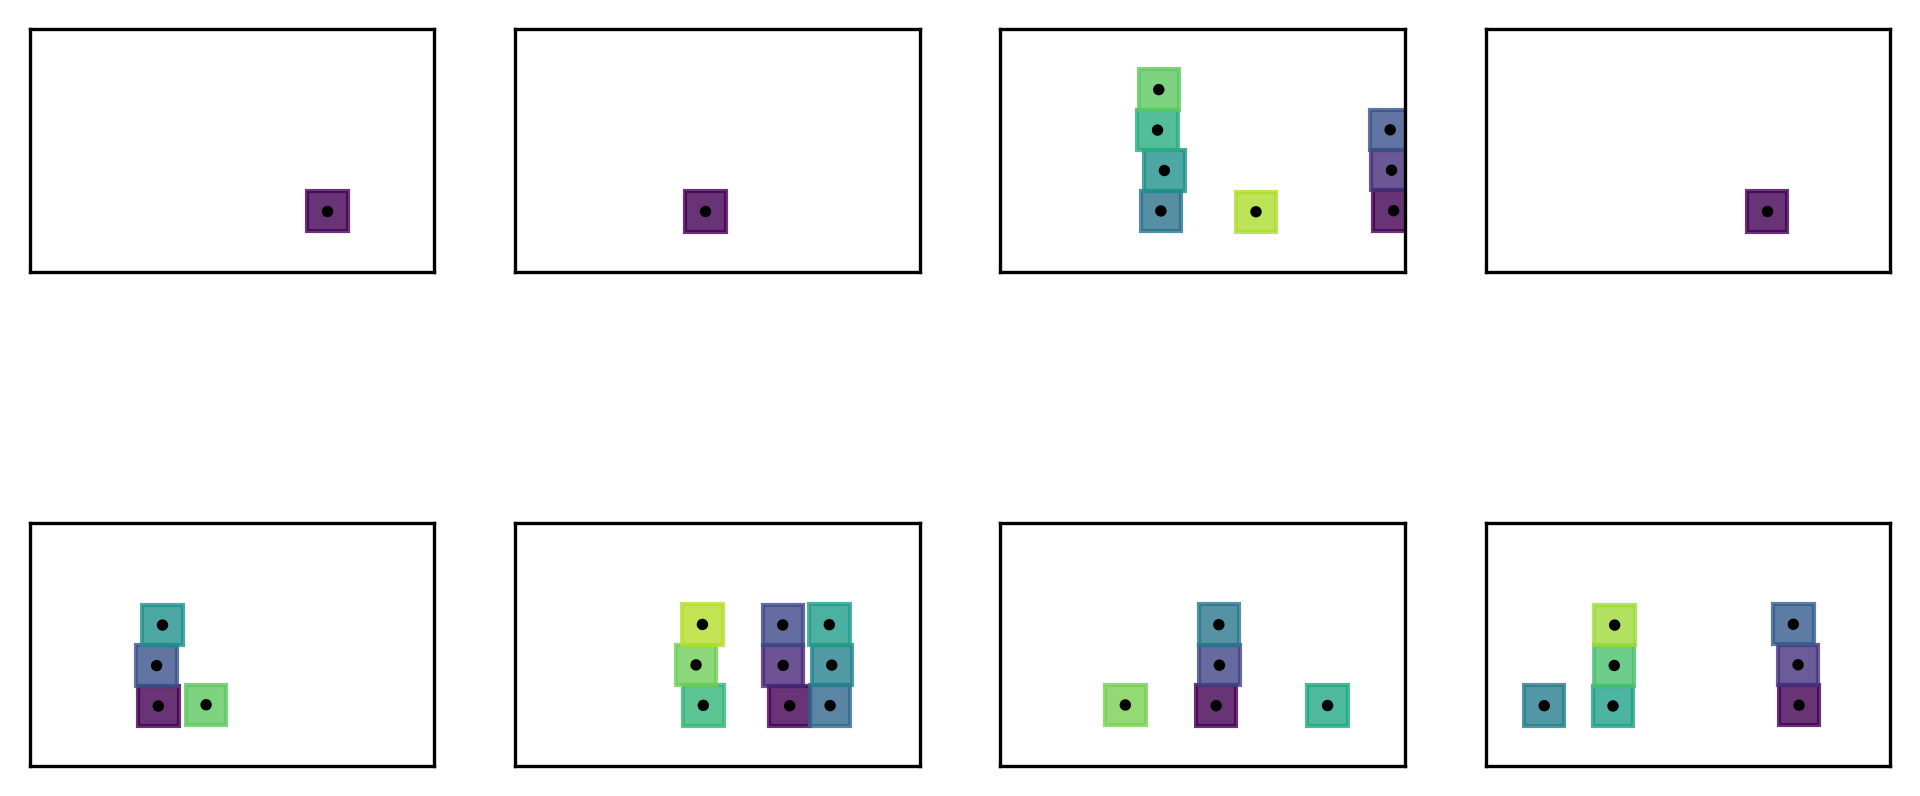

In [6]:
# Build observed trees
observed_trees = []
for tree in observed_full_trees:
    observed_tree = SceneTree()
    for node in tree:
        if isinstance(node, Box):
            observed_tree.add_node(node)
    observed_trees.append(observed_tree)

plt.figure(dpi=300).set_size_inches(8, 4)
fig = plt.gcf()
N_width = 4
N_height = 2
torch.random.manual_seed(42)
for i in range(N_width):
    for j in range(N_height):
        k = i*N_height + j
        ax = plt.subplot(N_height, N_width, k + 1)
        draw_boxes(observed_trees[k], fig=fig, ax=ax, block=False)
        ax.axis("on")
plt.show()

## Neural grammar proposal generator on various grammars

Train an encoder to take a set of observed nodes and produce distributions over grammar parameters that are more likely to have generated those specific nodes.

##### Encoder

Exceedingly simple encoder: GRU iterations over (randomly reordered) fixed-size embeddings of each observed node, where the input is a fixed-size embedding and hidden state is the parameters of the distribution over parameters . Embeddings are generated by per-observed-node-type networks to transform variable-size node parameters into a fixed size parameter vector. 

#### Decoder and observation likelihood

A different scene grammar is a decoder: this could be the original grammar, or a different richer grammar that can generate everything the original grammar can. Given the inference grammar's parameters $z$, it induces a distribution over trees.

To train the whole system:
- Directly supervised: Given a full tree from the original grammar, the terminal nodes are encoded, and the inference grammar parameters is encouraged to be close to one that would generate the ground-truth full tree.
- Unsupervised: An observed node set is encoded. Grammars are sampled and trees forward-generated from them; each is scored against the observed node set using a supplied likelihood function. The embedding and encoder params are optimized with REINFORCE. I think that if the likelihood function ends up being an unbiased estimate of p(observed | grammar params) (perhaps by sampling trees and then computing p(observed | tree)), then this is exactly a VAE.

In [7]:
# Test out the observation likelihood.
observed_nodes = [n for n in observed_trees[2].nodes if isinstance(n, TerminalNode)]
candidate_nodes = [n for n in observed_trees[2].nodes if isinstance(n, TerminalNode)]
print(estimate_observation_likelihood(candidate_nodes, observed_nodes, 1./np.sqrt(2*np.pi)))

tensor([0.], grad_fn=<DivBackward0>)


In [8]:
# Make a bigger dataset of observed trees
full_trees_for_training = []
observed_nodes_for_training = []
def make_dataset(N=100):
    full_trees = []
    observed_nodes = []
    for k in range(N):
        scene_trees, success = sample_tree_from_grammar_with_constraints(
            grammar,
            constraints=[
                NonpenetrationConstraint(0.001),
            ],
            max_num_attempts=1000,
            backend="rejection",#"metropolis_procedural_modeling",
        )
        if not success:
            continue
        full_trees.append(scene_trees[0])
        observed_nodes.append([n for n in scene_trees[0].nodes if isinstance(n, TerminalNode)])
    return full_trees, observed_nodes
full_trees_for_training, observed_nodes_for_training = make_dataset(400)
full_trees_for_testing, observed_nodes_for_testing = make_dataset(100)

In [9]:
# Try it out with an overparam'd form of the original grammar
inference_grammar = FullyParameterizedSuperTreeGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
#inference_grammar = FullyParameterizedGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
#inference_grammar = SceneGrammar(root_node_type=Ground, root_node_instantiation_dict=root_inst_dict)
config = GrammarEncoder.Config(rnn_type="GRU")
encoder = GrammarEncoder(inference_grammar, 512, config=config)
x = encoder(observed_nodes_for_training[0])

if 0:
    # Load encoder from saved run.
    weight_path = "saved_models/20210602/encoder_supervised_-202.3508.torch"
    encoder.load_state_dict(torch.load(weight_path))
    encoder.eval()

Text(0.5, 0.98, 'Draws from encoder/decoder before any training, on TEST')

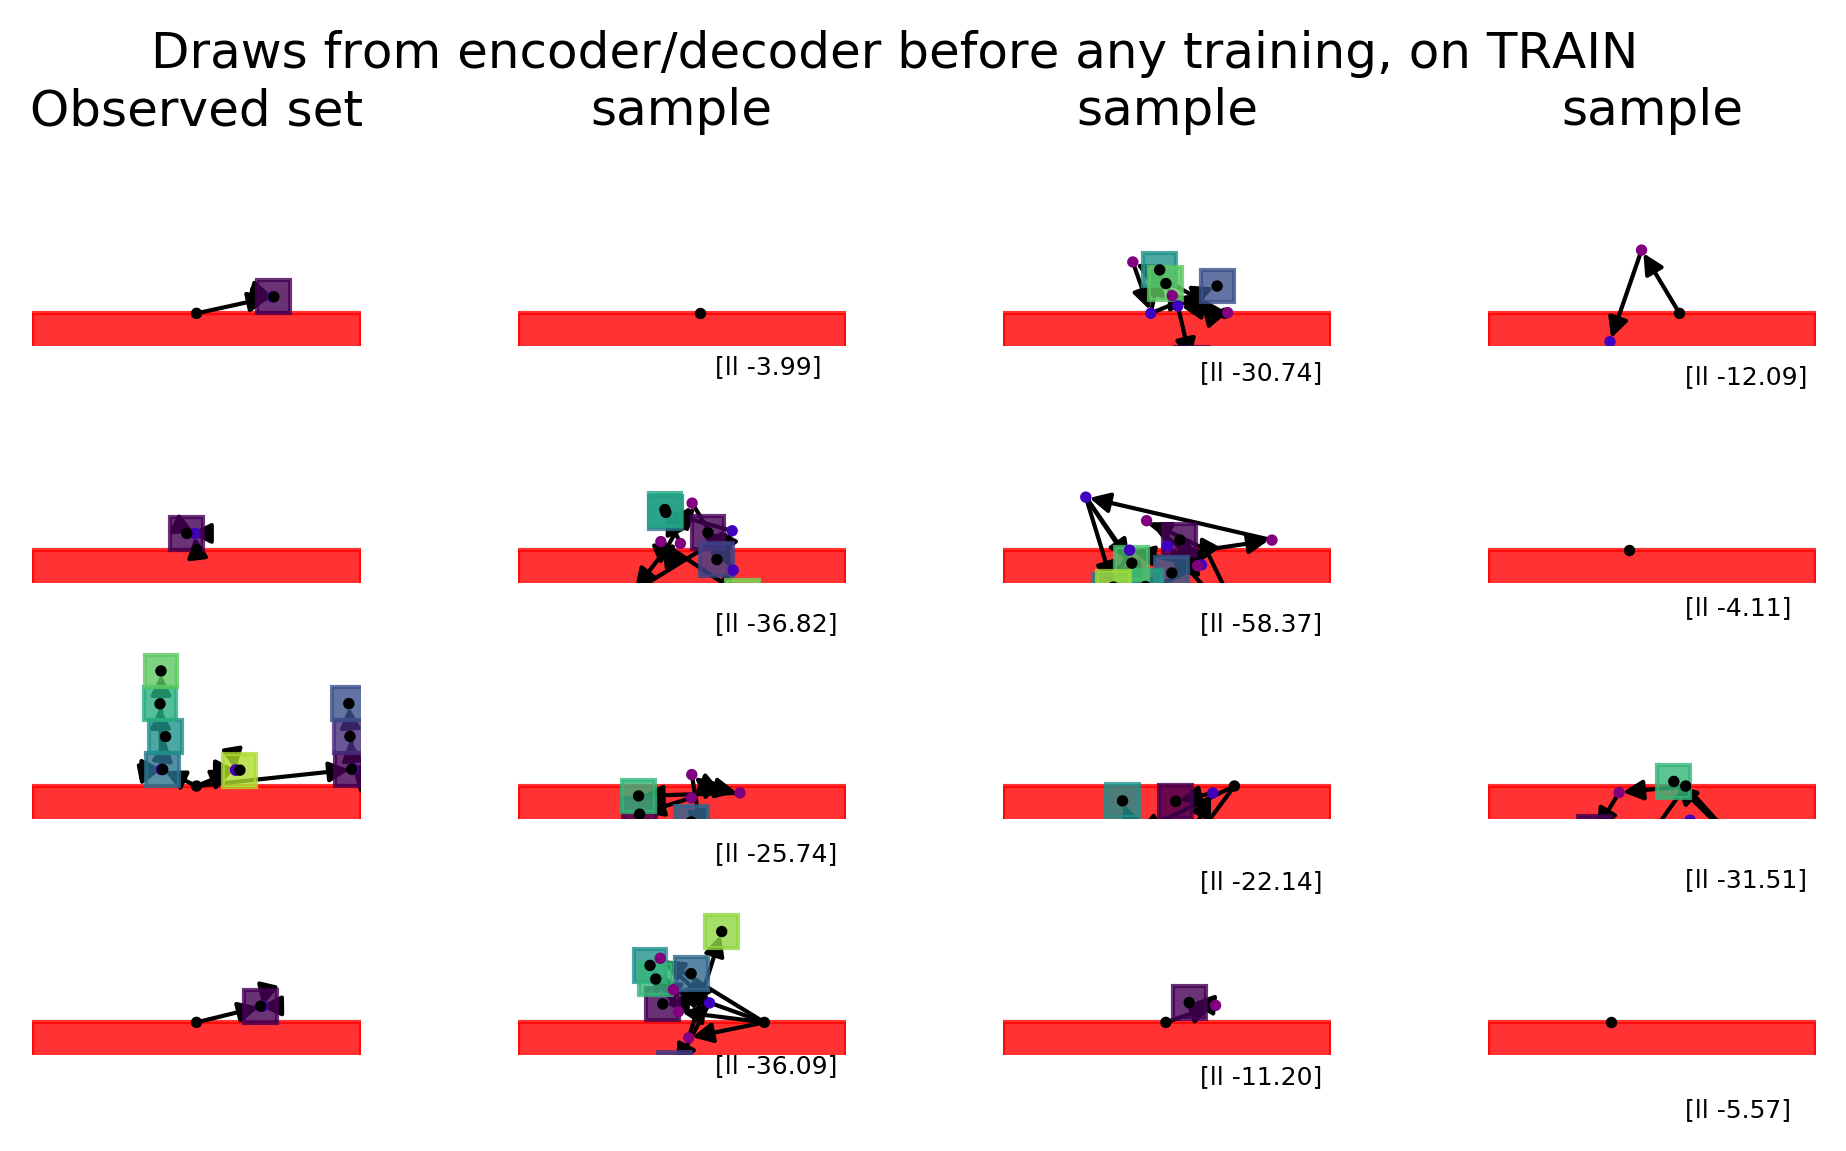

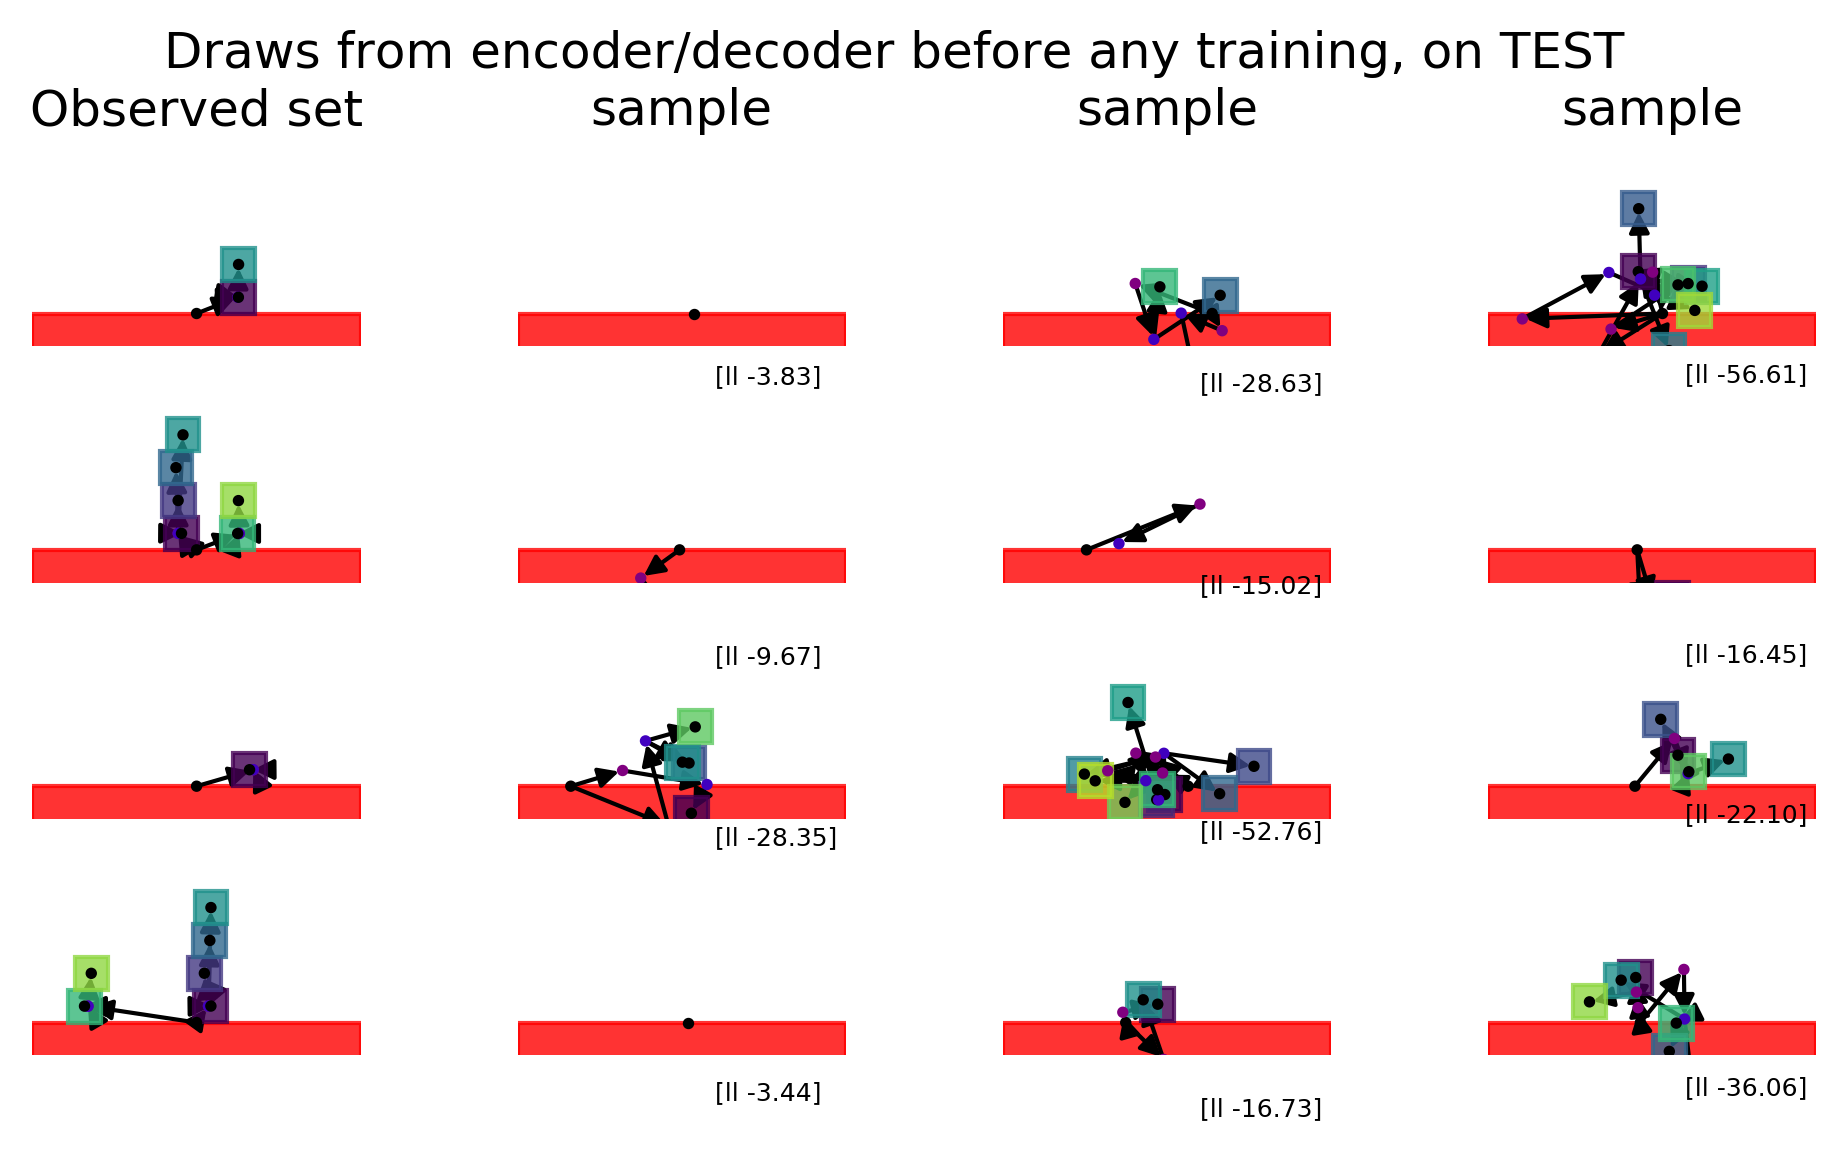

In [10]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 4
    N_height = 4
    torch.random.manual_seed(42)
    for i in range(N_height):
        plt.subplot(N_height, N_width, i*N_height + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        for j in range(1, N_width):
            k = i*N_height + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder before any training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder before any training, on TEST")

0: 106.679649
100: -62.032345
200: -95.108849
300: -110.766685
400: -118.693542


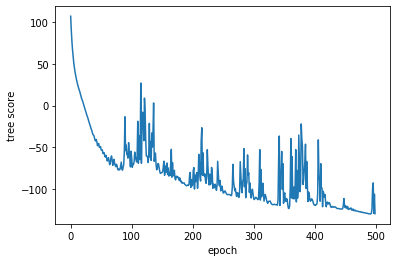

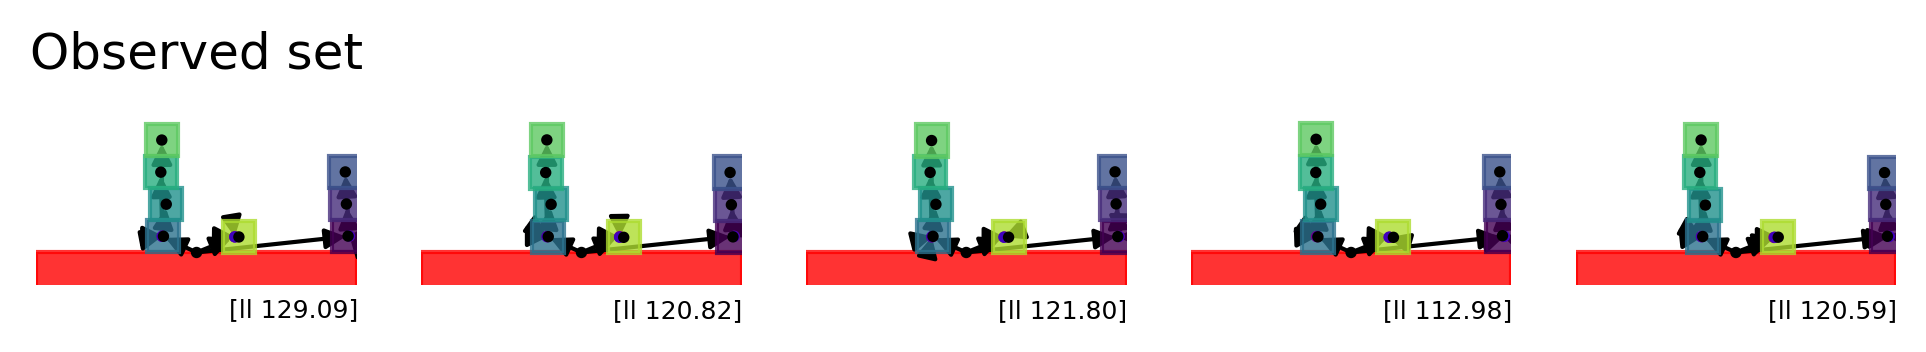

In [11]:
# Sanity-check grad descent: given a ground truth tree, can we
# recover the params of the auxiliary model that recover it?
full_tree = full_trees_for_training[2]
Nx = encoder.n_parameters
x = torch.normal(mean=torch.zeros(Nx), std=torch.ones(Nx)*0.1)
x.requires_grad = True
optimizer = torch.optim.Adam([x], lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=50, factor=0.5)
scores = []
for epoch in range(500):
    optimizer.zero_grad()
    score = -encoder.score_tree_with_grammar_vector(full_tree, x, detach=True)
    scores.append(score.detach().item())
    if epoch % 100 == 0:
        print("%d: %f" % (epoch, score))
    score.backward()
    optimizer.step()
    scheduler.step(score)
plt.plot(scores)
plt.xlabel("epoch")
plt.ylabel("tree score")
# Draw samples from the recovered vector
plt.figure(dpi=300).set_size_inches(8, 4)
N_width = 5
plt.subplot(1, N_width, 1)
draw_boxes(full_tree, fig=plt.gcf(), ax=plt.gca(), block=False)
plt.text(x=1., y=-2., s="[ll %0.2f]" % -score, fontsize=6)
plt.title("Observed set")
for k in range(N_width - 1):
    ax = plt.subplot(1, N_width, k + 2)
    plt.title("Sample %d" % k)
    sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
    draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
    plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

In [ ]:
# Sanity check a simpler auxiliary task: can the encoder spit out x s.t. the first element of x
# is the number of objects?
# Training
N_EPOCHS = 500
N_ITERS_PER_EPOCH = 10
CLIP_VALUE = 1E3
torch.manual_seed(1234)

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=50, factor=0.5)

total_objective_history = []
for epoch in range(N_EPOCHS):
    total_objective = 0.
    optimizer.zero_grad()

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        total_objective += torch.mean(torch.square(x[0] - len(observed_nodes)))
    
    mean_objective = total_objective / N_ITERS_PER_EPOCH
    total_objective_history.append(mean_objective)
    if (epoch % 10 == 0):
        print("%d:Mean objective %.2f, lr %f"
              % (epoch, mean_objective, optimizer.param_groups[0]['lr']))

    if torch.isfinite(mean_objective):
        (mean_objective).backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), CLIP_VALUE)
        optimizer.step()
        scheduler.step(mean_objective)
    time.sleep(0.05)
    
# Draw samples from the recovered vector
plt.figure(dpi=300).set_size_inches(8, 4)
N_width = 10
plt.subplot(1, N_width, 1)
for k in range(N_width):
    ax = plt.subplot(1, N_width, k + 1)
    plt.title("Sample %d" % k)
    observed_nodes = observed_nodes_for_testing[k]
    x = encoder(observed_nodes)
    draw_boxes(full_trees_for_testing[k], fig=fig, ax=ax, block=False)
    plt.title("%0.1f" % x[0].item(), fontsize=6)

# Supervised [pre]training using full trees

This is for training the encoder to be in the neighborhood of being reasonable: given an observed tree, encode its observed nodes to get an inference grammar parameter set x, and then score the ground truth tree under that parameter set; backprob through x to increase the log-prob of the ground truth tree.

In [16]:
# Training
N_EPOCHS = 5000
N_ITERS_PER_EPOCH = 50
CHECKPOINT_SAVE_PERIOD=250
CLIP_VALUE = 1E3
torch.manual_seed(1234)

def save_encoder_state(save_path):
    print("Saving to path ", save_path)
    try:
        dir_to_make = os.path.split(save_path)[0]
        if dir_to_make is not "":
            os.makedirs(dir_to_make)
    except FileExistsError:
        pass
    torch.save(encoder.state_dict(), save_path)
    print("Saved model to %s" % save_path)
    
checkpoint_save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime()),
    "checkpoints"
)

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=250, factor=0.5)

continuous_score_history = []
discrete_score_history = []
total_objective_history = []
score_history = []
all_gradients_history = {name: [] for name, _ in encoder.named_parameters()}
for epoch in range(N_EPOCHS):
    total_discrete_score = 0.
    total_continuous_score = 0.
    optimizer.zero_grad()

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        
        full_tree = full_trees_for_training[iter_k]
        discrete_score = encoder.score_tree_with_grammar_vector(
            full_tree, x, detach=True,
            include_discrete=True,
            include_continuous=False
        )
        total_discrete_score += discrete_score
        continuous_score = encoder.score_tree_with_grammar_vector(
            full_tree, x, detach=True,
            include_discrete=False,
            include_continuous=True
        )
        total_continuous_score += continuous_score
    
    mean_discrete_score = total_discrete_score / N_ITERS_PER_EPOCH
    mean_continuous_score = total_continuous_score / N_ITERS_PER_EPOCH
    
    discrete_score_history.append(mean_discrete_score.detach())
    continuous_score_history.append(mean_continuous_score.detach())

    # Weight continuous factor to bring it to the same order of
    # magnitude as the discrete score.
    #avg_d = torch.tensor(discrete_score_history[-AVERAGE_WINDOW]).mean()
    #avg_c = torch.tensor(continuous_score_history[-AVERAGE_WINDOW]).mean()
    
    mean_objective = mean_discrete_score * 10. + mean_continuous_score
    total_objective_history.append(mean_objective)
    score_history.append(mean_objective)
    if (epoch % 1 == 0):
        print("%d:Mean objective %.2f, discrete %.2f, continuous %.2f, lr %f"
              % (epoch, mean_objective, mean_discrete_score, mean_continuous_score,
                 optimizer.param_groups[0]['lr']))

    if torch.isfinite(mean_objective):
        (-mean_objective).backward()
        # log gradients
        for name, param in encoder.named_parameters():
            if param.grad is None:
                all_gradients_history[name].append(torch.zeros(param.shape))
            else:
                all_gradients_history[name].append(deepcopy(param.grad.data))

        torch.nn.utils.clip_grad_norm_(encoder.parameters(), CLIP_VALUE)
        optimizer.step()
        scheduler.step(mean_objective)
    time.sleep(0.05)
    
    if (epoch >= 0 and epoch % CHECKPOINT_SAVE_PERIOD == 0):
        save_encoder_state("saved_models/checkpoints/%d_%0.03f.torch" % (epoch, total_objective_history[-1]))

supervised_training_finish_time = time.time()

0:Mean objective -52.80, discrete -2.76, continuous -25.22, lr 0.001000
Saving to path  saved_models/checkpoints/0_-52.804.torch
Saved model to saved_models/checkpoints/0_-52.804.torch
1:Mean objective -22.54, discrete -1.67, continuous -5.83, lr 0.001000
2:Mean objective -27.63, discrete -2.06, continuous -7.08, lr 0.001000
3:Mean objective -25.56, discrete -1.92, continuous -6.38, lr 0.001000
4:Mean objective -25.60, discrete -2.14, continuous -4.25, lr 0.001000
5:Mean objective -23.18, discrete -1.97, continuous -3.51, lr 0.001000
6:Mean objective -27.21, discrete -2.47, continuous -2.55, lr 0.001000
7:Mean objective -30.83, discrete -2.75, continuous -3.28, lr 0.001000
8:Mean objective -27.83, discrete -2.58, continuous -2.08, lr 0.001000
9:Mean objective -20.98, discrete -2.06, continuous -0.37, lr 0.001000
10:Mean objective -22.75, discrete -2.28, continuous 0.10, lr 0.001000
11:Mean objective -26.31, discrete -2.54, continuous -0.95, lr 0.001000
12:Mean objective -23.44, discret

108:Mean objective -19.83, discrete -2.19, continuous 2.07, lr 0.001000
109:Mean objective -12.39, discrete -2.00, continuous 7.66, lr 0.001000
110:Mean objective -10.07, discrete -1.71, continuous 7.03, lr 0.001000
111:Mean objective -11.12, discrete -1.94, continuous 8.30, lr 0.001000
112:Mean objective -11.15, discrete -1.73, continuous 6.12, lr 0.001000
113:Mean objective -11.53, discrete -1.88, continuous 7.25, lr 0.001000
114:Mean objective -19.65, discrete -2.45, continuous 4.86, lr 0.001000
115:Mean objective -10.32, discrete -1.58, continuous 5.48, lr 0.001000
116:Mean objective -16.11, discrete -2.05, continuous 4.43, lr 0.001000
117:Mean objective -17.04, discrete -2.13, continuous 4.23, lr 0.001000
118:Mean objective -16.69, discrete -1.87, continuous 2.01, lr 0.001000
119:Mean objective -11.09, discrete -1.83, continuous 7.23, lr 0.001000
120:Mean objective -11.27, discrete -1.73, continuous 5.99, lr 0.001000
121:Mean objective -12.49, discrete -1.91, continuous 6.65, lr 0

216:Mean objective -11.32, discrete -1.83, continuous 6.94, lr 0.001000
217:Mean objective -6.37, discrete -1.68, continuous 10.47, lr 0.001000
218:Mean objective -12.06, discrete -1.86, continuous 6.51, lr 0.001000
219:Mean objective -15.05, discrete -2.14, continuous 6.39, lr 0.001000
220:Mean objective -8.92, discrete -1.69, continuous 8.03, lr 0.001000
221:Mean objective -6.23, discrete -1.50, continuous 8.81, lr 0.001000
222:Mean objective -10.42, discrete -1.95, continuous 9.04, lr 0.001000
223:Mean objective -8.66, discrete -1.69, continuous 8.21, lr 0.001000
224:Mean objective -7.39, discrete -1.63, continuous 8.89, lr 0.001000
225:Mean objective -9.76, discrete -1.86, continuous 8.82, lr 0.001000
Saving to path  saved_models/checkpoints/225_-9.762.torch
Saved model to saved_models/checkpoints/225_-9.762.torch
226:Mean objective -7.18, discrete -1.64, continuous 9.18, lr 0.001000
227:Mean objective -9.83, discrete -1.86, continuous 8.78, lr 0.001000
228:Mean objective -9.06, di

324:Mean objective -5.00, discrete -1.75, continuous 12.55, lr 0.001000
325:Mean objective -3.79, discrete -1.61, continuous 12.32, lr 0.001000
Saving to path  saved_models/checkpoints/325_-3.795.torch
Saved model to saved_models/checkpoints/325_-3.795.torch
326:Mean objective -4.69, discrete -1.64, continuous 11.72, lr 0.001000
327:Mean objective -5.49, discrete -1.59, continuous 10.45, lr 0.001000
328:Mean objective -0.96, discrete -1.33, continuous 12.35, lr 0.001000
329:Mean objective -3.64, discrete -1.68, continuous 13.19, lr 0.001000
330:Mean objective -6.12, discrete -1.75, continuous 11.36, lr 0.001000
331:Mean objective 1.49, discrete -1.16, continuous 13.07, lr 0.001000
332:Mean objective -6.43, discrete -1.65, continuous 10.05, lr 0.001000
333:Mean objective -1.52, discrete -1.35, continuous 12.00, lr 0.001000
334:Mean objective -3.70, discrete -1.52, continuous 11.49, lr 0.001000
335:Mean objective -5.55, discrete -1.73, continuous 11.73, lr 0.001000
336:Mean objective -4.

431:Mean objective -7.41, discrete -1.93, continuous 11.90, lr 0.001000
432:Mean objective 0.22, discrete -1.32, continuous 13.43, lr 0.001000
433:Mean objective -6.06, discrete -1.73, continuous 11.24, lr 0.001000
434:Mean objective -3.27, discrete -1.73, continuous 14.08, lr 0.001000
435:Mean objective -6.11, discrete -1.78, continuous 11.71, lr 0.001000
436:Mean objective -2.67, discrete -1.52, continuous 12.56, lr 0.001000
437:Mean objective -4.48, discrete -1.71, continuous 12.60, lr 0.001000
438:Mean objective -8.44, discrete -2.11, continuous 12.63, lr 0.001000
439:Mean objective -3.73, discrete -1.67, continuous 12.95, lr 0.001000
440:Mean objective -1.56, discrete -1.55, continuous 13.93, lr 0.001000
441:Mean objective -2.19, discrete -1.57, continuous 13.53, lr 0.001000
442:Mean objective 1.51, discrete -1.29, continuous 14.45, lr 0.001000
443:Mean objective -4.11, discrete -1.70, continuous 12.92, lr 0.001000
444:Mean objective -3.61, discrete -1.73, continuous 13.74, lr 0.0

539:Mean objective 4.52, discrete -1.06, continuous 15.12, lr 0.001000
540:Mean objective 2.62, discrete -1.28, continuous 15.44, lr 0.001000
541:Mean objective 0.14, discrete -1.54, continuous 15.49, lr 0.001000
542:Mean objective -3.24, discrete -1.71, continuous 13.87, lr 0.001000
543:Mean objective 0.18, discrete -1.44, continuous 14.58, lr 0.001000
544:Mean objective 1.14, discrete -1.40, continuous 15.12, lr 0.001000
545:Mean objective 1.84, discrete -1.34, continuous 15.27, lr 0.001000
546:Mean objective 3.48, discrete -1.28, continuous 16.28, lr 0.001000
547:Mean objective -2.18, discrete -1.66, continuous 14.38, lr 0.001000
548:Mean objective 0.06, discrete -1.63, continuous 16.34, lr 0.001000
549:Mean objective 4.31, discrete -1.27, continuous 17.02, lr 0.001000
550:Mean objective -0.29, discrete -1.51, continuous 14.80, lr 0.001000
Saving to path  saved_models/checkpoints/550_-0.287.torch
Saved model to saved_models/checkpoints/550_-0.287.torch
551:Mean objective 0.47, discr

648:Mean objective 0.04, discrete -1.51, continuous 15.14, lr 0.001000
649:Mean objective 1.17, discrete -1.29, continuous 14.06, lr 0.001000
650:Mean objective 5.65, discrete -1.16, continuous 17.21, lr 0.001000
Saving to path  saved_models/checkpoints/650_5.651.torch
Saved model to saved_models/checkpoints/650_5.651.torch
651:Mean objective 2.00, discrete -1.22, continuous 14.20, lr 0.001000
652:Mean objective 1.39, discrete -1.43, continuous 15.71, lr 0.001000
653:Mean objective 2.24, discrete -1.28, continuous 15.05, lr 0.001000
654:Mean objective 4.86, discrete -1.20, continuous 16.89, lr 0.001000
655:Mean objective 2.65, discrete -1.28, continuous 15.46, lr 0.001000
656:Mean objective 3.97, discrete -1.18, continuous 15.80, lr 0.001000
657:Mean objective 4.56, discrete -1.16, continuous 16.19, lr 0.001000
658:Mean objective 3.97, discrete -1.30, continuous 16.99, lr 0.001000
659:Mean objective 3.73, discrete -1.36, continuous 17.29, lr 0.001000
660:Mean objective 2.86, discrete -

756:Mean objective 3.16, discrete -1.29, continuous 16.07, lr 0.001000
757:Mean objective 3.45, discrete -1.21, continuous 15.51, lr 0.001000
758:Mean objective 0.36, discrete -1.29, continuous 13.31, lr 0.001000
759:Mean objective 2.41, discrete -1.15, continuous 13.91, lr 0.001000
760:Mean objective 2.62, discrete -0.93, continuous 11.97, lr 0.001000
761:Mean objective 4.31, discrete -1.02, continuous 14.55, lr 0.001000
762:Mean objective -5.85, discrete -1.26, continuous 6.79, lr 0.001000
763:Mean objective -5.78, discrete -1.37, continuous 7.93, lr 0.001000
764:Mean objective 0.86, discrete -1.29, continuous 13.81, lr 0.001000
765:Mean objective -1.36, discrete -1.28, continuous 11.41, lr 0.001000
766:Mean objective -1.05, discrete -1.22, continuous 11.15, lr 0.001000
767:Mean objective 1.22, discrete -1.31, continuous 14.36, lr 0.001000
768:Mean objective 4.43, discrete -1.10, continuous 15.40, lr 0.001000
769:Mean objective 2.38, discrete -1.32, continuous 15.57, lr 0.001000
770:

865:Mean objective 3.28, discrete -1.11, continuous 14.37, lr 0.001000
866:Mean objective 0.90, discrete -1.23, continuous 13.21, lr 0.001000
867:Mean objective 1.36, discrete -0.99, continuous 11.23, lr 0.001000
868:Mean objective -6.46, discrete -1.10, continuous 4.54, lr 0.001000
869:Mean objective 7.17, discrete -0.86, continuous 15.82, lr 0.001000
870:Mean objective 5.30, discrete -0.98, continuous 15.10, lr 0.001000
871:Mean objective 3.43, discrete -0.97, continuous 13.16, lr 0.001000
872:Mean objective 0.66, discrete -1.16, continuous 12.27, lr 0.001000
873:Mean objective 1.49, discrete -1.18, continuous 13.28, lr 0.001000
874:Mean objective 7.56, discrete -0.79, continuous 15.44, lr 0.001000
875:Mean objective 4.82, discrete -1.08, continuous 15.60, lr 0.001000
Saving to path  saved_models/checkpoints/875_4.817.torch
Saved model to saved_models/checkpoints/875_4.817.torch
876:Mean objective -2.74, discrete -1.36, continuous 10.86, lr 0.001000
877:Mean objective 2.70, discrete 

974:Mean objective 7.67, discrete -0.93, continuous 16.95, lr 0.001000
975:Mean objective 7.48, discrete -0.85, continuous 15.96, lr 0.001000
Saving to path  saved_models/checkpoints/975_7.481.torch
Saved model to saved_models/checkpoints/975_7.481.torch
976:Mean objective 8.10, discrete -0.87, continuous 16.82, lr 0.001000
977:Mean objective 4.83, discrete -0.86, continuous 13.43, lr 0.001000
978:Mean objective 6.12, discrete -0.88, continuous 14.91, lr 0.001000
979:Mean objective 4.42, discrete -0.88, continuous 13.20, lr 0.001000
980:Mean objective 2.11, discrete -1.03, continuous 12.39, lr 0.001000
981:Mean objective 5.04, discrete -0.84, continuous 13.46, lr 0.001000
982:Mean objective 4.31, discrete -1.00, continuous 14.30, lr 0.001000
983:Mean objective 5.54, discrete -0.90, continuous 14.58, lr 0.001000
984:Mean objective 7.07, discrete -0.84, continuous 15.45, lr 0.001000
985:Mean objective 5.94, discrete -1.06, continuous 16.51, lr 0.001000
986:Mean objective 7.63, discrete -

1080:Mean objective 8.96, discrete -0.89, continuous 17.86, lr 0.001000
1081:Mean objective 3.36, discrete -0.89, continuous 12.27, lr 0.001000
1082:Mean objective 4.36, discrete -0.80, continuous 12.36, lr 0.001000
1083:Mean objective 4.55, discrete -0.78, continuous 12.38, lr 0.001000
1084:Mean objective 7.78, discrete -0.75, continuous 15.24, lr 0.001000
1085:Mean objective 8.60, discrete -0.79, continuous 16.49, lr 0.001000
1086:Mean objective 6.02, discrete -0.76, continuous 13.67, lr 0.001000
1087:Mean objective 10.44, discrete -0.71, continuous 17.49, lr 0.001000
1088:Mean objective 9.30, discrete -0.74, continuous 16.67, lr 0.001000
1089:Mean objective 11.91, discrete -0.75, continuous 19.37, lr 0.001000
1090:Mean objective 8.22, discrete -0.87, continuous 16.96, lr 0.001000
1091:Mean objective 13.06, discrete -0.58, continuous 18.85, lr 0.001000
1092:Mean objective 12.03, discrete -0.62, continuous 18.24, lr 0.001000
1093:Mean objective 10.75, discrete -0.66, continuous 17.38,

1187:Mean objective 6.73, discrete -0.79, continuous 14.64, lr 0.001000
1188:Mean objective 11.59, discrete -0.51, continuous 16.65, lr 0.001000
1189:Mean objective 10.15, discrete -0.59, continuous 16.03, lr 0.001000
1190:Mean objective 8.34, discrete -0.74, continuous 15.71, lr 0.001000
1191:Mean objective 8.23, discrete -0.73, continuous 15.51, lr 0.001000
1192:Mean objective 4.52, discrete -0.72, continuous 11.68, lr 0.001000
1193:Mean objective 0.51, discrete -0.91, continuous 9.60, lr 0.001000
1194:Mean objective 5.97, discrete -0.65, continuous 12.44, lr 0.001000
1195:Mean objective 7.12, discrete -0.70, continuous 14.08, lr 0.001000
1196:Mean objective 8.48, discrete -0.72, continuous 15.73, lr 0.001000
1197:Mean objective 11.76, discrete -0.60, continuous 17.75, lr 0.001000
1198:Mean objective 9.85, discrete -0.70, continuous 16.84, lr 0.001000
1199:Mean objective 10.74, discrete -0.65, continuous 17.21, lr 0.001000
1200:Mean objective 9.56, discrete -0.69, continuous 16.47, l

1294:Mean objective 13.84, discrete -0.64, continuous 20.20, lr 0.001000
1295:Mean objective 12.74, discrete -0.56, continuous 18.33, lr 0.001000
1296:Mean objective 10.09, discrete -0.69, continuous 17.02, lr 0.001000
1297:Mean objective 12.66, discrete -0.58, continuous 18.44, lr 0.001000
1298:Mean objective 8.80, discrete -0.59, continuous 14.68, lr 0.001000
1299:Mean objective 7.77, discrete -0.69, continuous 14.68, lr 0.001000
1300:Mean objective 7.44, discrete -0.63, continuous 13.72, lr 0.001000
Saving to path  saved_models/checkpoints/1300_7.440.torch
Saved model to saved_models/checkpoints/1300_7.440.torch
1301:Mean objective 8.46, discrete -0.60, continuous 14.48, lr 0.001000
1302:Mean objective 11.34, discrete -0.60, continuous 17.35, lr 0.001000
1303:Mean objective 13.45, discrete -0.62, continuous 19.64, lr 0.001000
1304:Mean objective 13.35, discrete -0.59, continuous 19.25, lr 0.001000
1305:Mean objective 12.74, discrete -0.56, continuous 18.32, lr 0.001000
1306:Mean obj

Saving to path  saved_models/checkpoints/1400_12.611.torch
Saved model to saved_models/checkpoints/1400_12.611.torch
1401:Mean objective 12.04, discrete -0.58, continuous 17.89, lr 0.001000
1402:Mean objective 11.66, discrete -0.48, continuous 16.45, lr 0.001000
1403:Mean objective 13.37, discrete -0.58, continuous 19.21, lr 0.001000
1404:Mean objective 6.36, discrete -0.62, continuous 12.51, lr 0.001000
1405:Mean objective 6.88, discrete -0.49, continuous 11.81, lr 0.001000
1406:Mean objective 10.72, discrete -0.64, continuous 17.07, lr 0.001000
1407:Mean objective 10.62, discrete -0.54, continuous 16.01, lr 0.001000
1408:Mean objective 10.09, discrete -0.49, continuous 14.95, lr 0.001000
1409:Mean objective 12.79, discrete -0.55, continuous 18.28, lr 0.001000
1410:Mean objective 13.35, discrete -0.54, continuous 18.80, lr 0.001000
1411:Mean objective 12.57, discrete -0.55, continuous 18.05, lr 0.001000
1412:Mean objective 12.12, discrete -0.51, continuous 17.23, lr 0.001000
1413:Mean

1506:Mean objective 12.47, discrete -0.48, continuous 17.30, lr 0.001000
1507:Mean objective 10.27, discrete -0.61, continuous 16.41, lr 0.001000
1508:Mean objective 15.73, discrete -0.36, continuous 19.32, lr 0.001000
1509:Mean objective 12.19, discrete -0.47, continuous 16.87, lr 0.001000
1510:Mean objective 13.11, discrete -0.46, continuous 17.70, lr 0.001000
1511:Mean objective 14.38, discrete -0.41, continuous 18.46, lr 0.001000
1512:Mean objective 15.12, discrete -0.40, continuous 19.10, lr 0.001000
1513:Mean objective 11.85, discrete -0.56, continuous 17.49, lr 0.001000
1514:Mean objective 11.60, discrete -0.50, continuous 16.58, lr 0.001000
1515:Mean objective 14.78, discrete -0.49, continuous 19.68, lr 0.001000
1516:Mean objective 13.94, discrete -0.48, continuous 18.72, lr 0.001000
1517:Mean objective 15.86, discrete -0.47, continuous 20.53, lr 0.001000
1518:Mean objective 12.58, discrete -0.49, continuous 17.49, lr 0.001000
1519:Mean objective 12.35, discrete -0.51, continuo

1612:Mean objective 13.18, discrete -0.46, continuous 17.77, lr 0.001000
1613:Mean objective 15.56, discrete -0.38, continuous 19.31, lr 0.001000
1614:Mean objective 13.93, discrete -0.47, continuous 18.60, lr 0.001000
1615:Mean objective 15.11, discrete -0.43, continuous 19.44, lr 0.001000
1616:Mean objective 12.65, discrete -0.49, continuous 17.50, lr 0.001000
1617:Mean objective 12.40, discrete -0.50, continuous 17.43, lr 0.001000
1618:Mean objective 13.45, discrete -0.52, continuous 18.66, lr 0.001000
1619:Mean objective 13.75, discrete -0.43, continuous 18.00, lr 0.001000
1620:Mean objective 13.09, discrete -0.49, continuous 17.98, lr 0.001000
1621:Mean objective 13.79, discrete -0.48, continuous 18.60, lr 0.001000
1622:Mean objective 13.87, discrete -0.51, continuous 19.01, lr 0.001000
1623:Mean objective 15.09, discrete -0.46, continuous 19.66, lr 0.001000
1624:Mean objective 17.38, discrete -0.37, continuous 21.12, lr 0.001000
1625:Mean objective 17.22, discrete -0.40, continuo

1718:Mean objective 15.05, discrete -0.40, continuous 19.01, lr 0.001000
1719:Mean objective 15.63, discrete -0.36, continuous 19.23, lr 0.001000
1720:Mean objective 14.19, discrete -0.41, continuous 18.32, lr 0.001000
1721:Mean objective 13.56, discrete -0.38, continuous 17.34, lr 0.001000
1722:Mean objective 11.96, discrete -0.50, continuous 16.93, lr 0.001000
1723:Mean objective 7.08, discrete -0.36, continuous 10.72, lr 0.001000
1724:Mean objective 11.81, discrete -0.35, continuous 15.29, lr 0.001000
1725:Mean objective 13.67, discrete -0.37, continuous 17.33, lr 0.001000
Saving to path  saved_models/checkpoints/1725_13.671.torch
Saved model to saved_models/checkpoints/1725_13.671.torch
1726:Mean objective 9.97, discrete -0.48, continuous 14.79, lr 0.001000
1727:Mean objective 10.43, discrete -0.33, continuous 13.71, lr 0.001000
1728:Mean objective 15.62, discrete -0.41, continuous 19.77, lr 0.001000
1729:Mean objective 12.49, discrete -0.43, continuous 16.77, lr 0.001000
1730:Mean

1824:Mean objective 17.32, discrete -0.43, continuous 21.60, lr 0.001000
1825:Mean objective 14.83, discrete -0.44, continuous 19.28, lr 0.001000
Saving to path  saved_models/checkpoints/1825_14.833.torch
Saved model to saved_models/checkpoints/1825_14.833.torch
1826:Mean objective 15.55, discrete -0.34, continuous 18.93, lr 0.001000
1827:Mean objective 15.58, discrete -0.34, continuous 19.02, lr 0.001000
1828:Mean objective 18.95, discrete -0.26, continuous 21.55, lr 0.001000
1829:Mean objective 14.92, discrete -0.40, continuous 18.94, lr 0.001000
1830:Mean objective 13.66, discrete -0.42, continuous 17.81, lr 0.001000
1831:Mean objective 15.66, discrete -0.41, continuous 19.71, lr 0.001000
1832:Mean objective 16.18, discrete -0.31, continuous 19.23, lr 0.001000
1833:Mean objective 16.07, discrete -0.34, continuous 19.49, lr 0.001000
1834:Mean objective 15.27, discrete -0.32, continuous 18.43, lr 0.001000
1835:Mean objective 13.74, discrete -0.47, continuous 18.42, lr 0.001000
1836:Me

1929:Mean objective 15.73, discrete -0.34, continuous 19.12, lr 0.001000
1930:Mean objective 17.53, discrete -0.31, continuous 20.62, lr 0.001000
1931:Mean objective 16.38, discrete -0.39, continuous 20.26, lr 0.001000
1932:Mean objective 17.33, discrete -0.39, continuous 21.28, lr 0.001000
1933:Mean objective 18.90, discrete -0.31, continuous 22.02, lr 0.001000
1934:Mean objective 19.46, discrete -0.35, continuous 22.98, lr 0.001000
1935:Mean objective 16.92, discrete -0.36, continuous 20.57, lr 0.001000
1936:Mean objective 17.99, discrete -0.38, continuous 21.81, lr 0.001000
1937:Mean objective 19.34, discrete -0.27, continuous 22.06, lr 0.001000
1938:Mean objective 19.79, discrete -0.29, continuous 22.69, lr 0.001000
1939:Mean objective 17.42, discrete -0.35, continuous 20.94, lr 0.001000
1940:Mean objective 17.37, discrete -0.39, continuous 21.25, lr 0.001000
1941:Mean objective 17.84, discrete -0.42, continuous 22.08, lr 0.001000
1942:Mean objective 18.68, discrete -0.36, continuo

2035:Mean objective 18.97, discrete -0.33, continuous 22.24, lr 0.001000
2036:Mean objective 18.38, discrete -0.25, continuous 20.91, lr 0.001000
2037:Mean objective 18.54, discrete -0.27, continuous 21.21, lr 0.001000
2038:Mean objective 17.18, discrete -0.37, continuous 20.91, lr 0.001000
2039:Mean objective 16.44, discrete -0.31, continuous 19.56, lr 0.001000
2040:Mean objective 17.26, discrete -0.39, continuous 21.19, lr 0.001000
2041:Mean objective 19.93, discrete -0.31, continuous 22.98, lr 0.001000
2042:Mean objective 18.24, discrete -0.39, continuous 22.19, lr 0.001000
2043:Mean objective 17.70, discrete -0.29, continuous 20.65, lr 0.001000
2044:Mean objective 19.06, discrete -0.26, continuous 21.67, lr 0.001000
2045:Mean objective 17.94, discrete -0.33, continuous 21.24, lr 0.001000
2046:Mean objective 16.49, discrete -0.32, continuous 19.67, lr 0.001000
2047:Mean objective 17.08, discrete -0.37, continuous 20.81, lr 0.001000
2048:Mean objective 20.21, discrete -0.34, continuo

KeyboardInterrupt: 

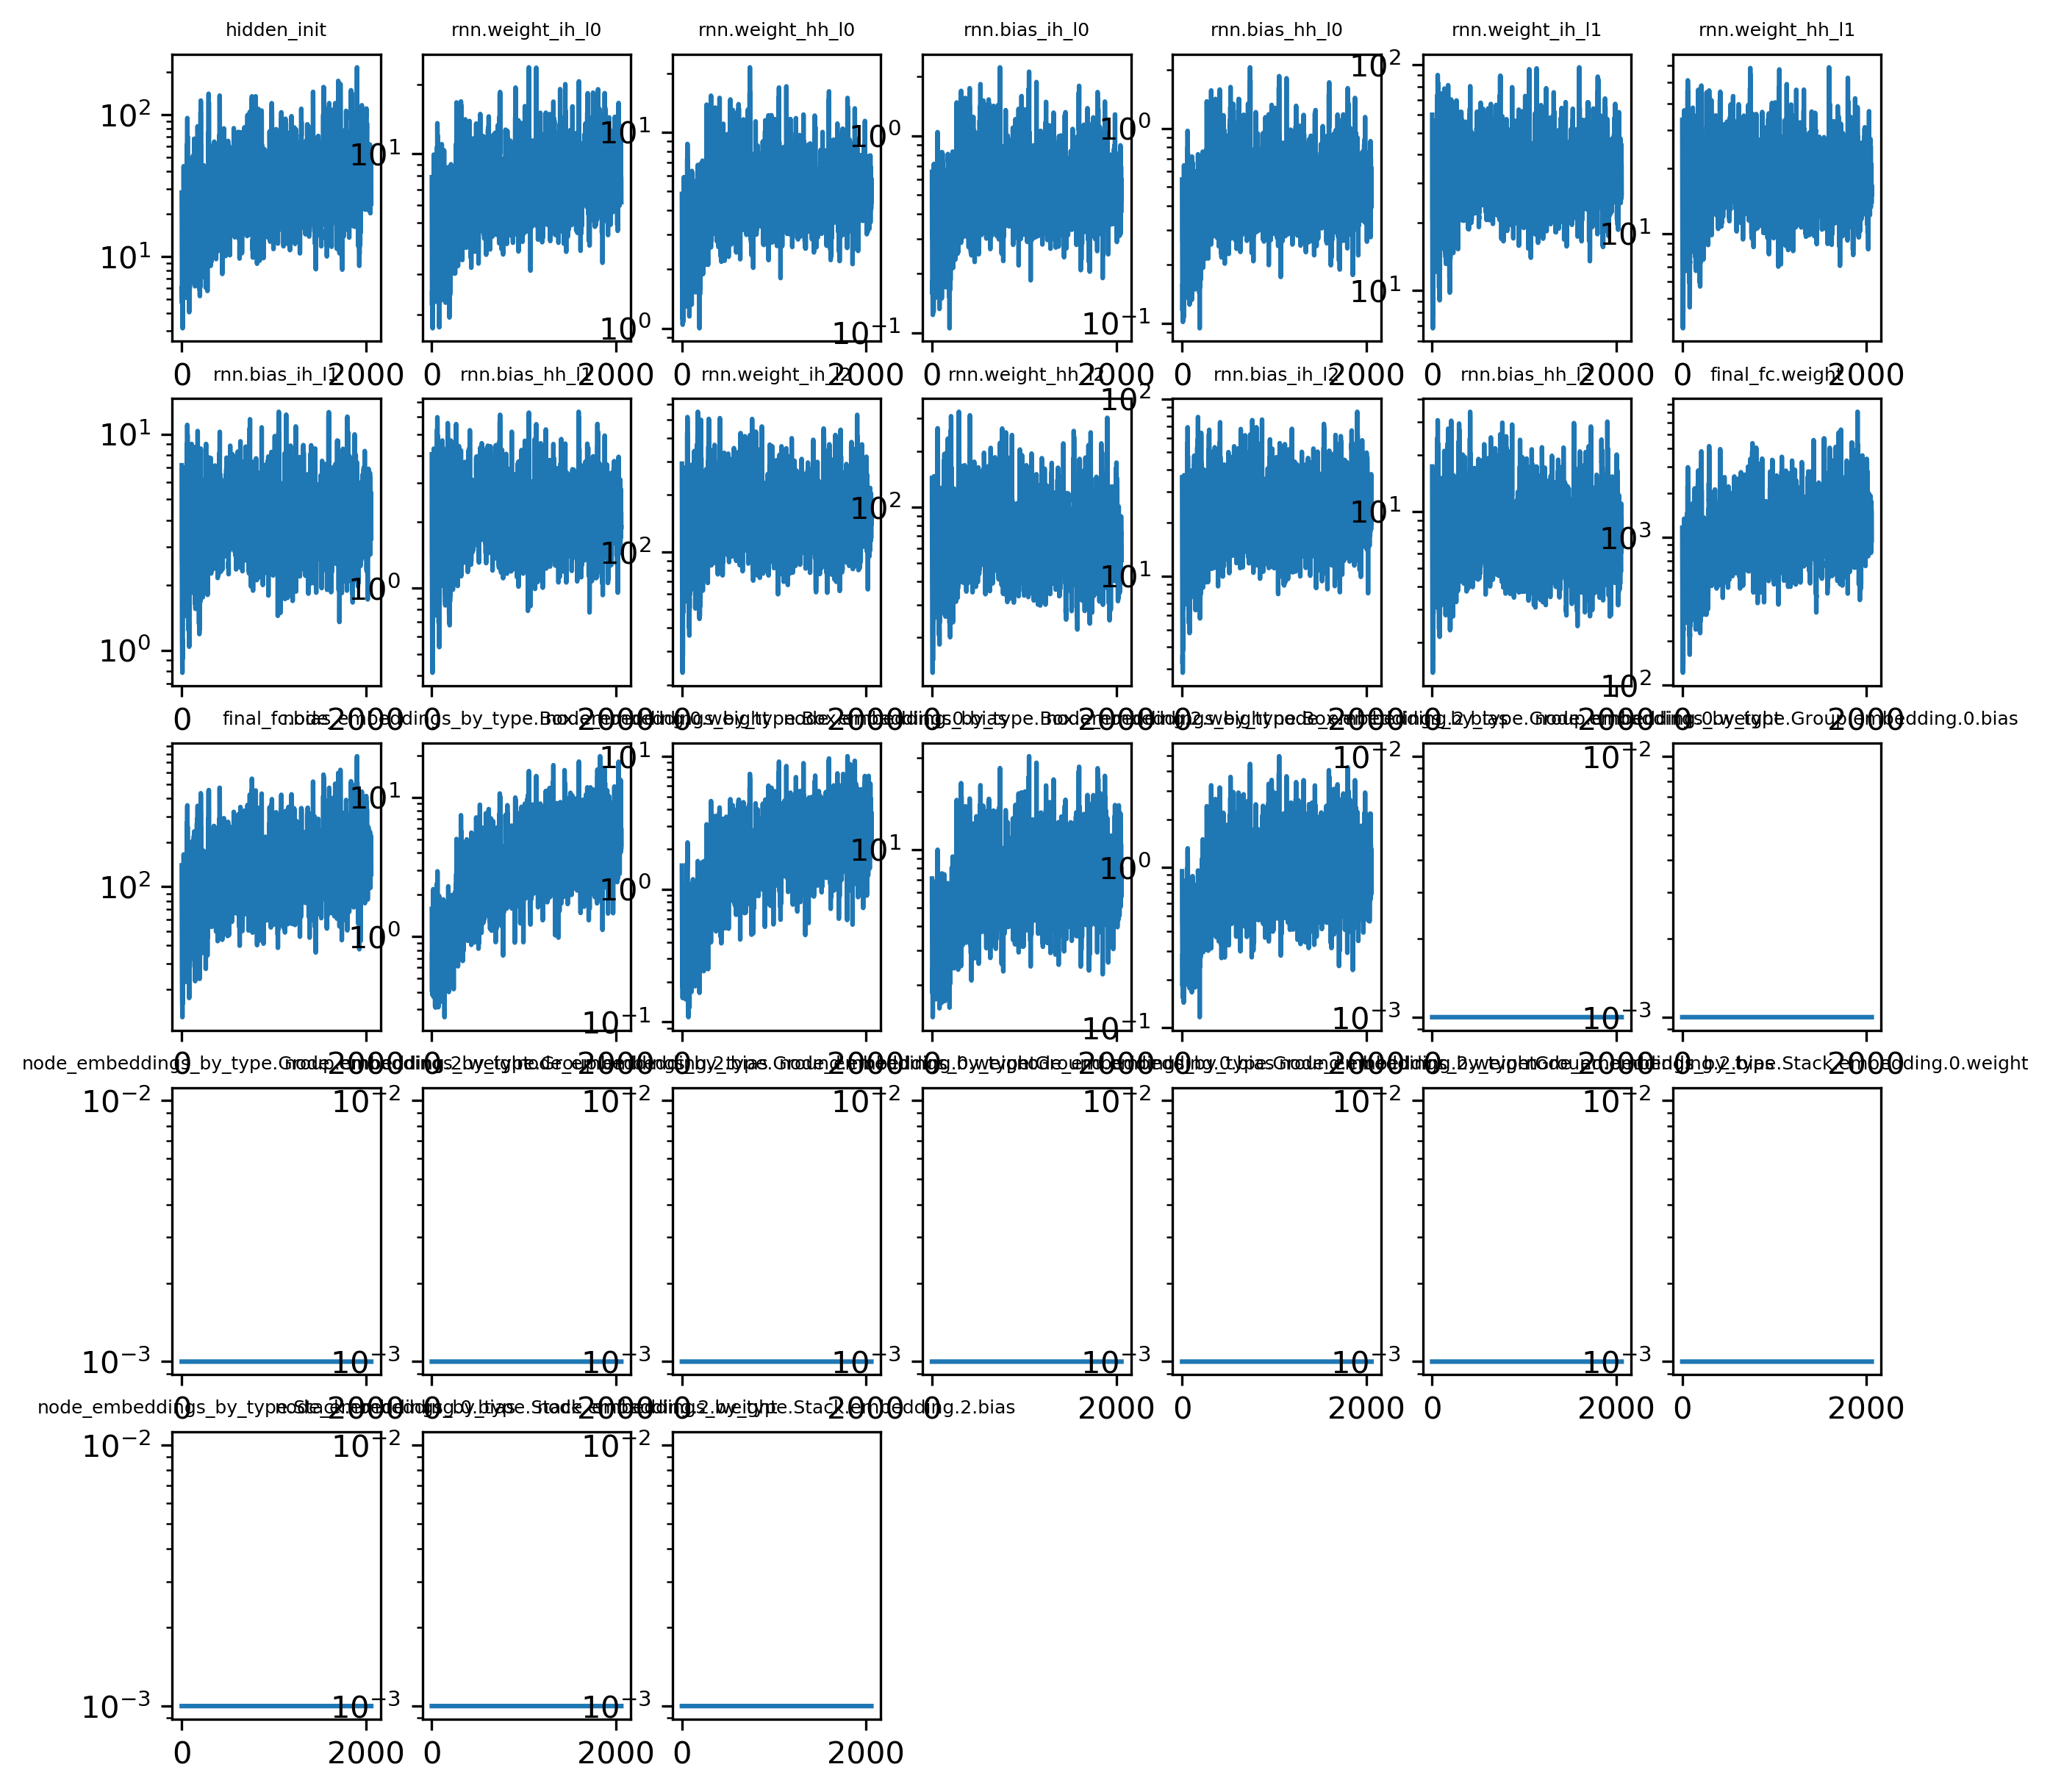

In [20]:
# Draw gradient norm history per param
plt.figure(dpi=300).set_size_inches(10, 10)
n_params = len(all_gradients_history.keys())
for k, (name, history) in enumerate(all_gradients_history.items()):
    ax = plt.subplot(5, n_params // 5 + 1, k+1)
    history = torch.stack(history)
    history = np.linalg.norm(history.reshape(history.shape[0], -1).numpy(), axis=1) + 1E-3
    x = range(history.shape[0])
    ax.plot(x, history)
    plt.yscale("log")
    #ax.fill_between(x, (means-std), (means+std), color='b', alpha=.1)
    plt.title(name, fontsize=6)

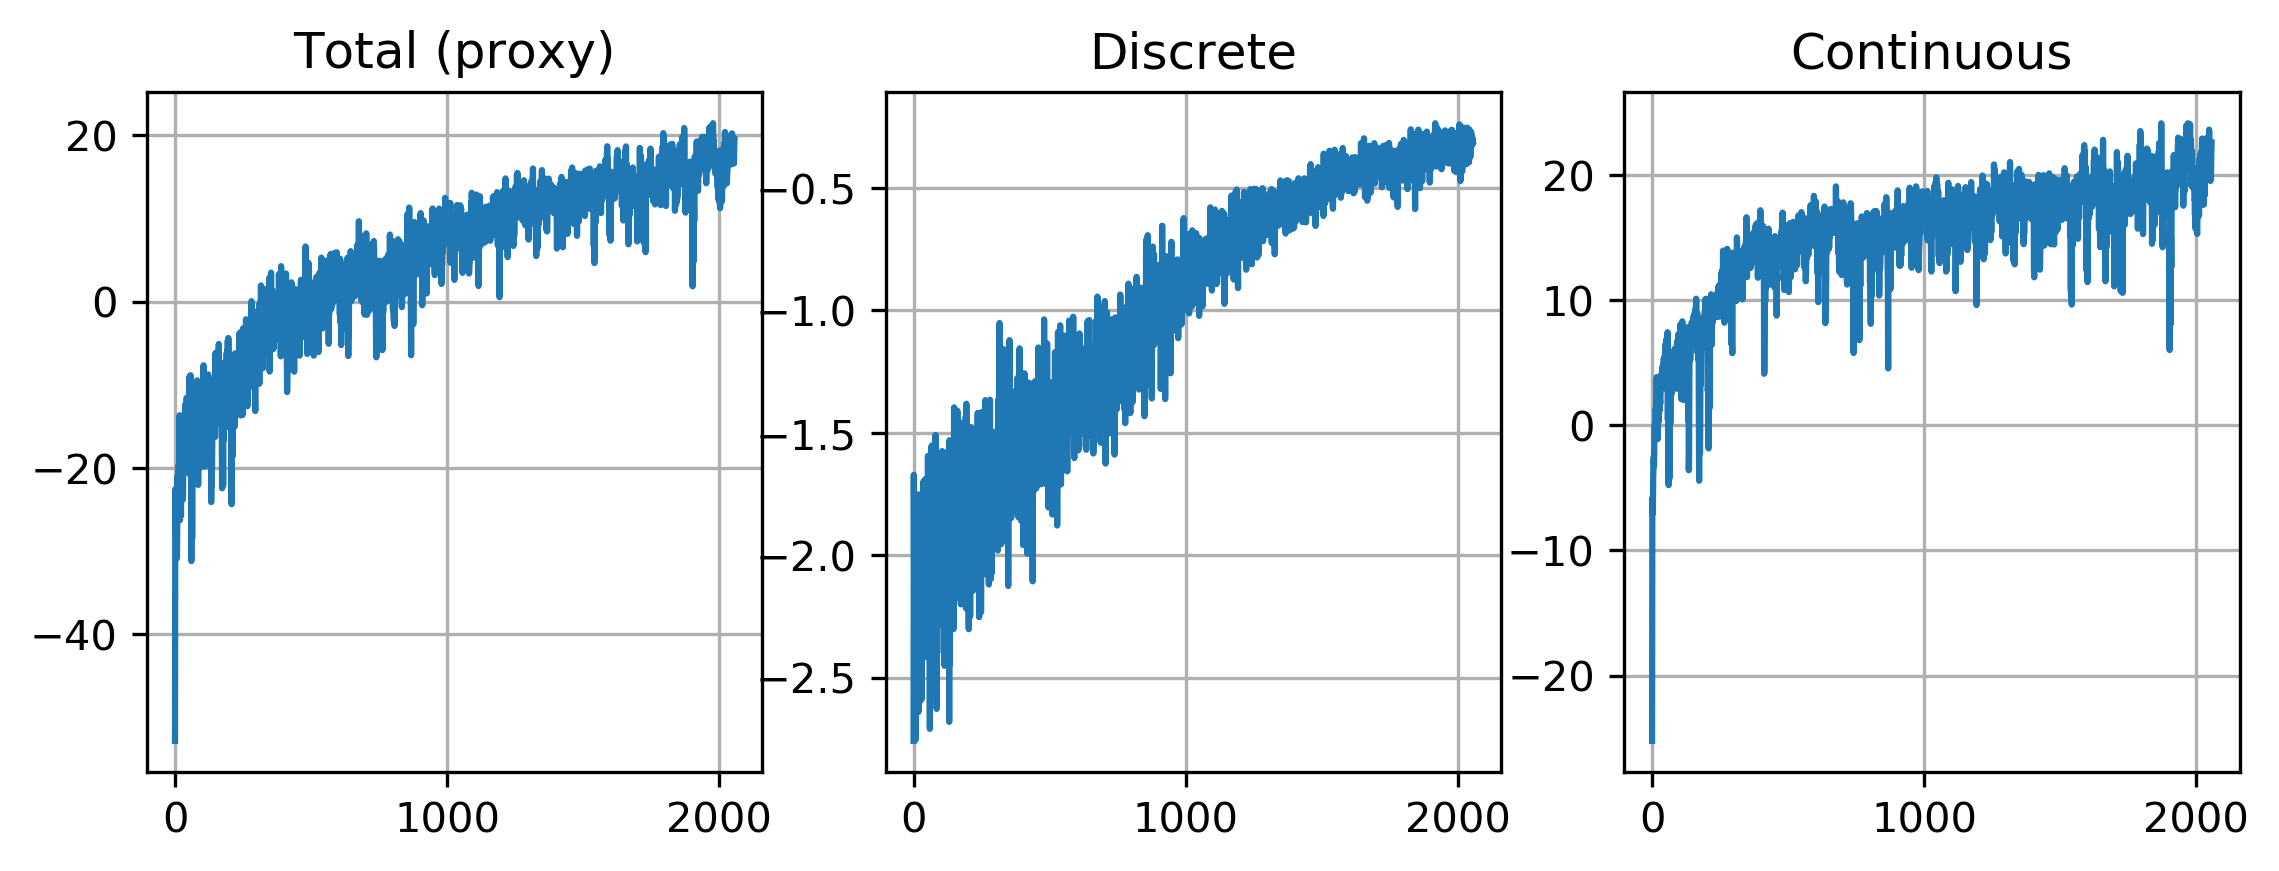

In [22]:
def set_reasonable_bounds(hist, lb, ub):
    low = max(np.min(hist) - 1. , lb)
    high = min(np.max(hist) + 1., ub)
plt.figure(dpi=300).set_size_inches(9, 3)
plt.subplot(1, 3, 1)
plt.title("Total (proxy)")
plt.plot(total_objective_history)
set_reasonable_bounds(total_objective_history, -40, 100.)
plt.grid(True)
plt.subplot(1, 3, 2)
plt.title("Discrete")
plt.plot(discrete_score_history)
set_reasonable_bounds(discrete_score_history, -40., 100.)
plt.grid(True)
plt.subplot(1, 3, 3)
plt.title("Continuous")
plt.plot(continuous_score_history)
plt.grid(True)
set_reasonable_bounds(continuous_score_history, -40., 100)

Entering example  0
Entering example  1
Entering example  2
Entering example  3
Entering example  0
Entering example  1
Entering example  2
Entering example  3


Text(0.5, 0.98, 'Draws from encoder/decoder after supervised training, on TEST')

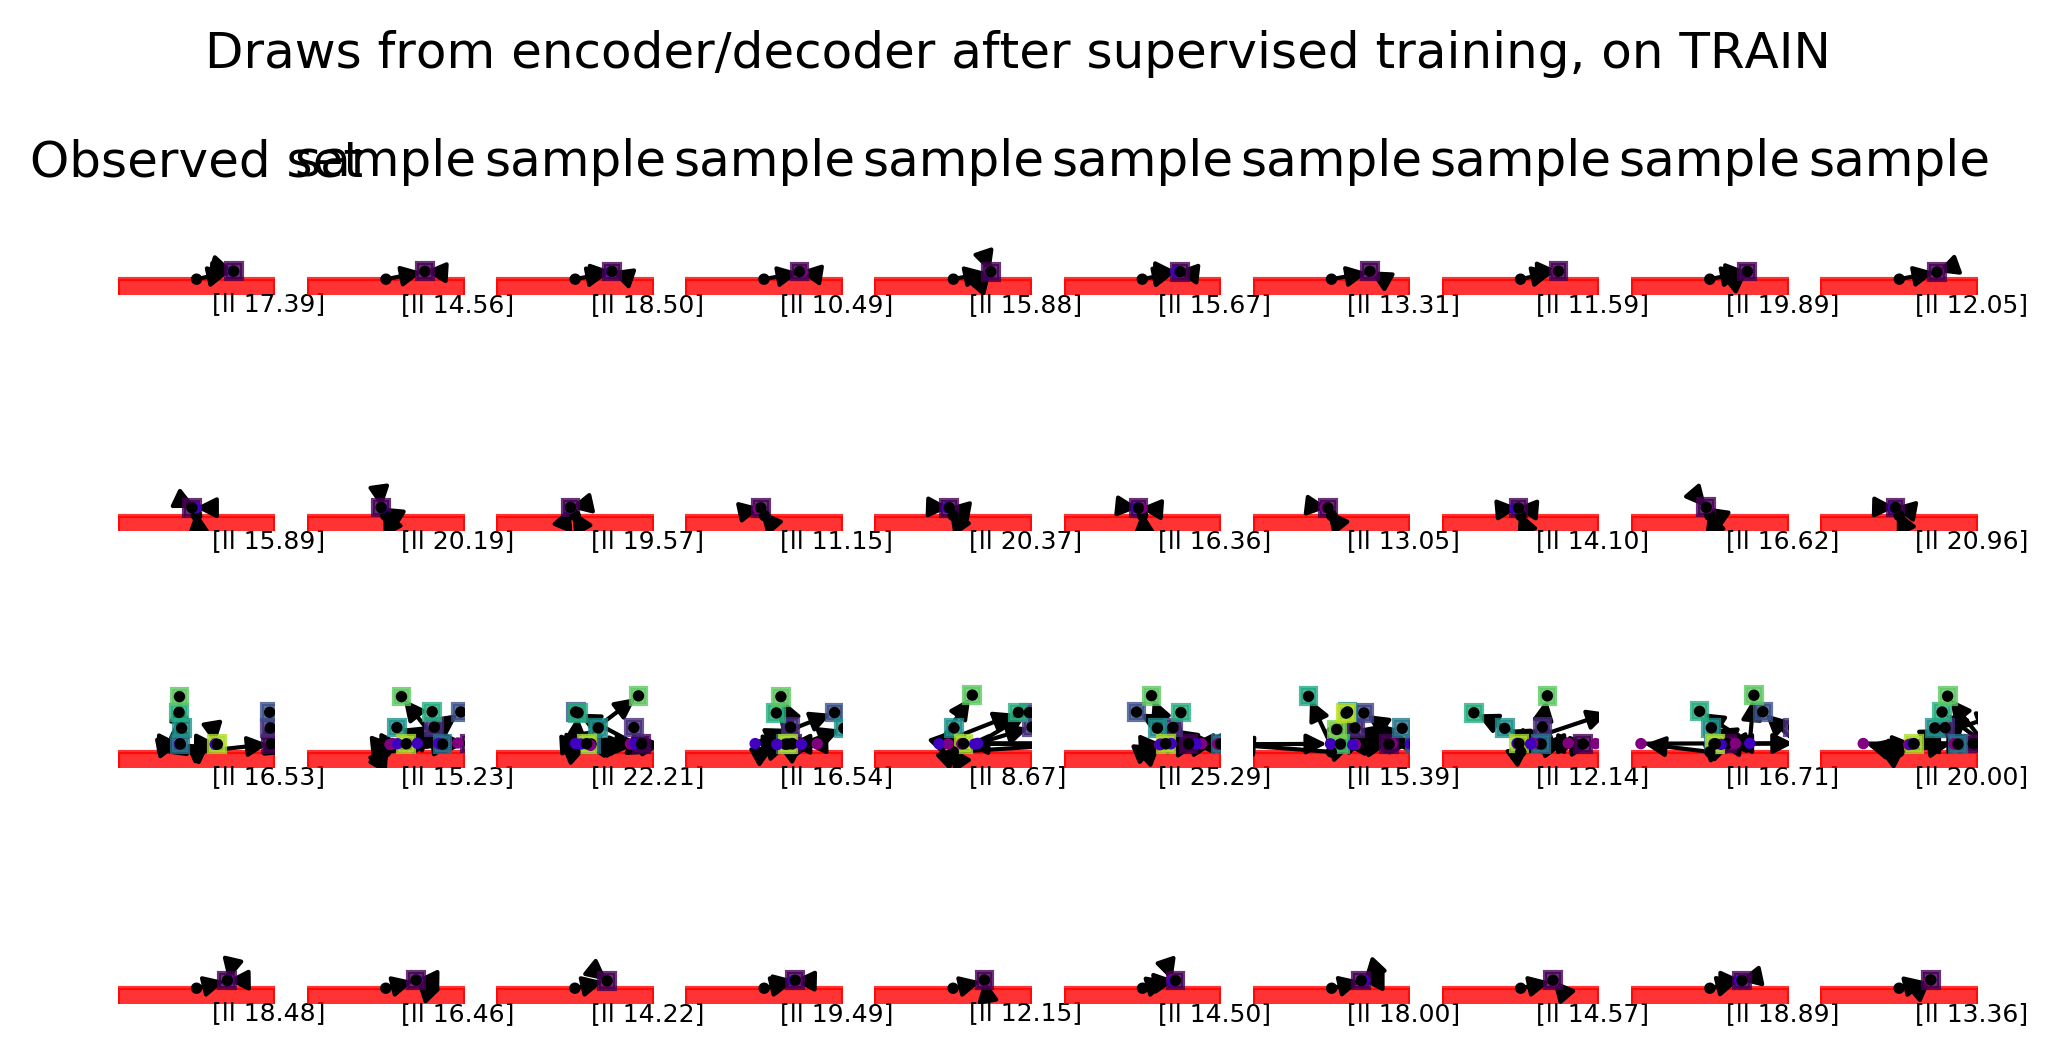

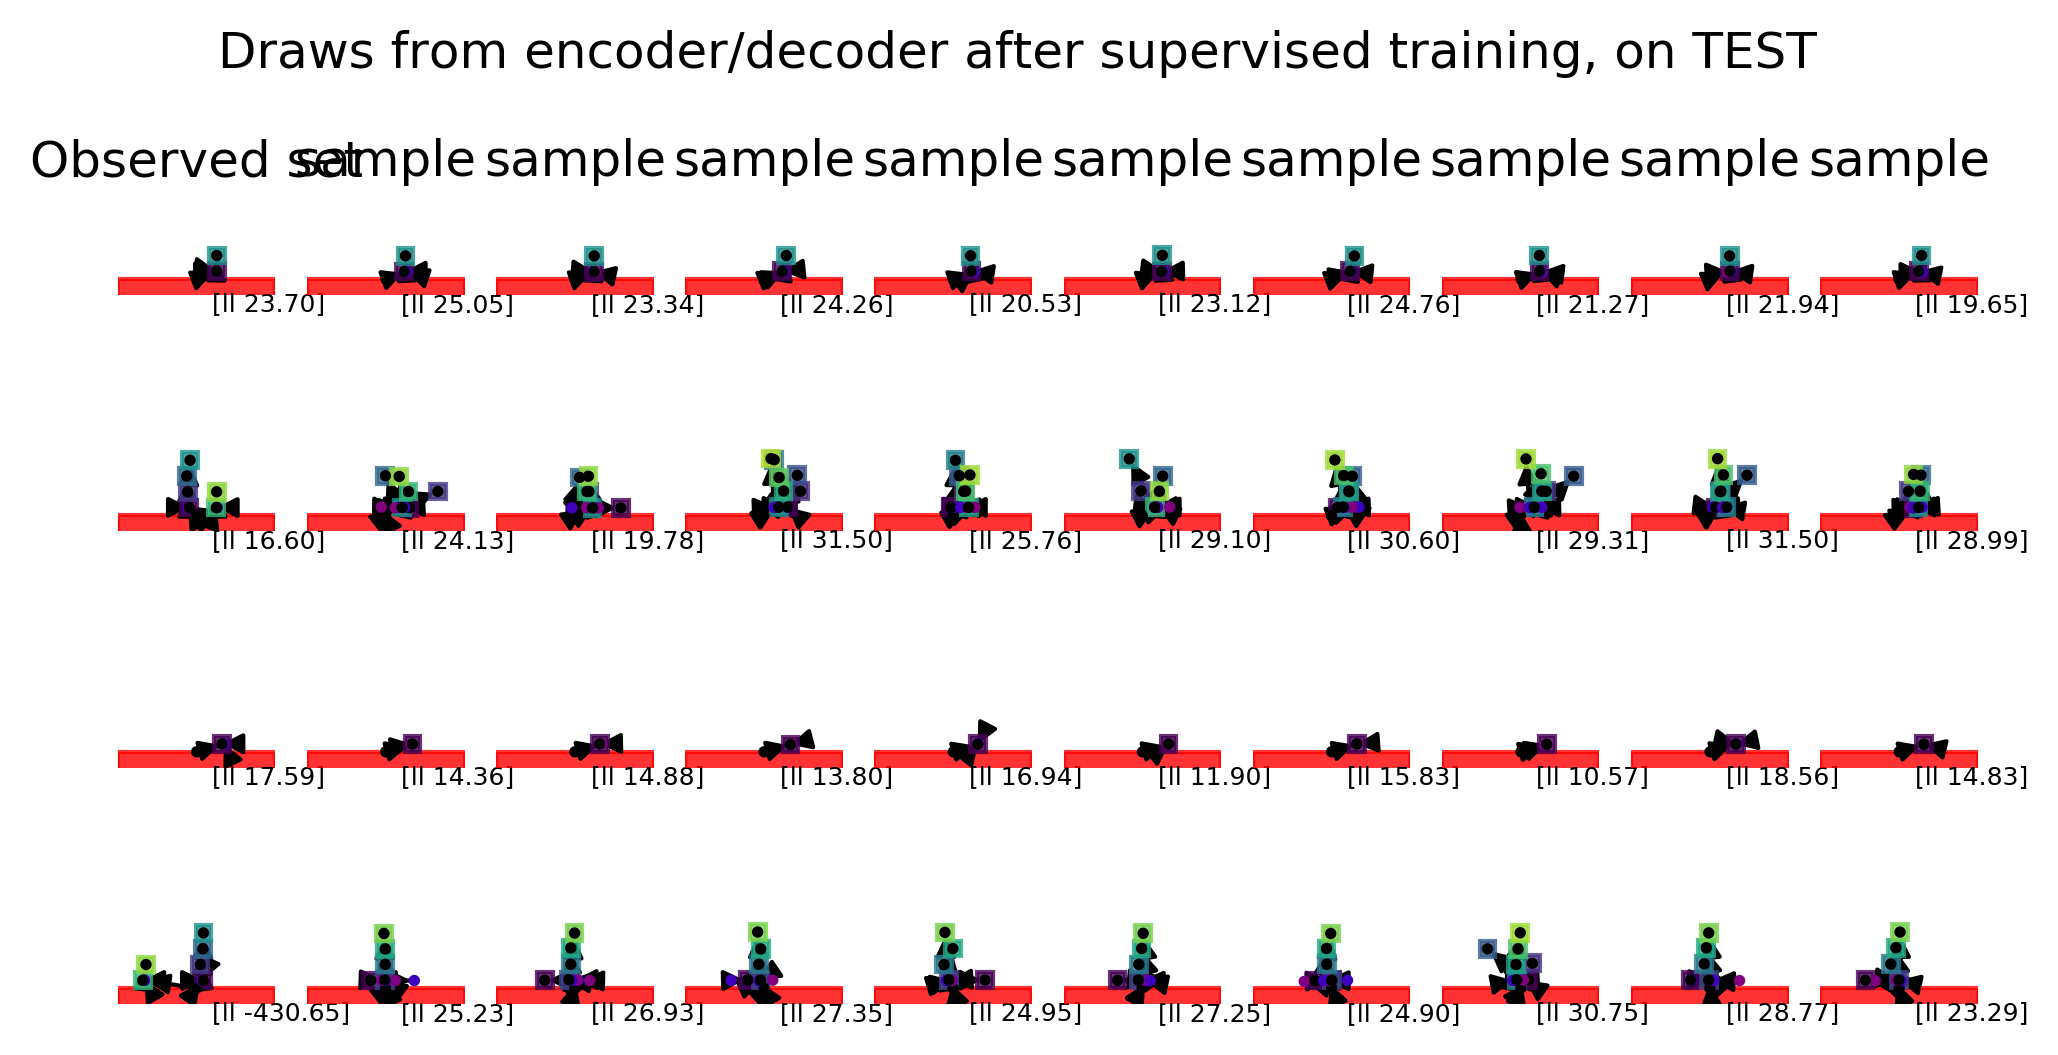

In [18]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 10
    N_height = 4
    torch.random.manual_seed(41)
    
    for i in range(N_height):
        print("Entering example ", i)
        plt.subplot(N_height, N_width, i*N_width + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        
        # Score the test tree under its encoded vector
        density = encoder.score_tree_with_grammar_vector(full_trees[i], x, include_continuous=True)
        plt.text(x=1., y=-2., s="[ll %0.2f]" % density, fontsize=6)
        
        for j in range(1, N_width):
            k = i*N_width + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, _, _ = encoder.sample_tree_from_grammar_vector(x)
            proposal_density = encoder.score_tree_with_grammar_vector(sampled_tree, x, include_continuous=True)
            #box_k = 0
            #for node in sampled_tree.nodes:
            #    if isinstance(node, Box):
            #        node.xy = torch.tensor([0., box_k])
            #        box_k += 1
            #    else:
            #        node.xy = torch.zeros(2)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder after supervised training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder after supervised training, on TEST")

In [19]:
# Save output
save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime())
)
save_name = "encoder_supervised_gru_%0.04f.torch" % (
    total_objective_history[-1]
)
save_path = os.path.join(save_dir, save_name)
save_encoder_state(save_name)

Saving to path  encoder_supervised_gru_19.4932.torch
Saved model to encoder_supervised_gru_19.4932.torch


# Autoencoder Loss Training via Reinforce

Encoding is deterministic, but decoding involves drawing samples of trees from that distribution. I'll notate that whole parameterized enc-decode sampling as drawing $t \sim q_\theta(t^*)$.

To first see if things work, I'd like to directly optimize a loss function $f$ that roughly enforces observed node similarity while being close to the proposal density prior and original grammar prior  $max_\theta E_{t \sim q_\theta(t^*)}\Big[ f(t, t^*) \Big] + log p(\theta)$, for $f(t, t^*) = L(t, t^*) + p(t)$.

So we've unfortunately to use REINFORCE since the decoder is a complex sampling procedure, so our gradient estimate is $E_{t \sim q_\theta(t^*)}\Big[ (f(t, t^*) \nabla_\theta \log q_\theta(t^*) \Big] + log p(\theta) $. (Since I'm operating in pytorch, I'll build a surrogate objective that has that gradient.)


In [ ]:
# Training
N_EPOCHS = 450
N_ITERS_PER_EPOCH = 10
N_SAMPLES_PER_ENCODING = 5
MIN_LL_SATURATION = -10000

torch.manual_seed(43)

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150,300], gamma=0.33)
mean_sampled_f_history = []
mean_sampled_score_history = []
total_objective_history = []
for epoch in range(N_EPOCHS):
    total_objective = 0.
    total_sampled_f = 0.
    total_sampled_score = 0.
    total_num_samples = 0
    optimizer.zero_grad()

    if len(mean_sampled_f_history) == 0:
        decaying_avg_baseline = 0.
    elif len(mean_sampled_f_history) < 10:
        decaying_avg_baseline = torch.mean(torch.tensor(mean_sampled_f_history))
    else:
        decaying_avg_baseline = torch.mean(torch.tensor(mean_sampled_f_history[-10:]))

    # Iterate over part of the observed node set in random order.
    iter_order = torch.randperm(len(observed_nodes_for_training))
    for iter_k in iter_order[:N_ITERS_PER_EPOCH]:
        observed_nodes = observed_nodes_for_training[iter_k]
        x = encoder(observed_nodes)
        # Calculate contribution of encoding prior (very weak, just keeps values from
        # blowing up.)
        #x_prior_ll = dist.Normal(0., 10.).log_prob(x).sum()
        #total_objective += x_prior_ll * N_SAMPLES_PER_ENCODING
        for sample_k in range(N_SAMPLES_PER_ENCODING):
            sampled_tree, proposal_density_ll, nonreparam_density_ll = encoder.sample_tree_from_grammar_vector(x)
            candidate_nodes = [n for n in sampled_tree.nodes if isinstance(n, TerminalNode)]
            
            # Calculate observation matching score.
            est_ll = (estimate_observation_likelihood(candidate_nodes, observed_nodes, 0.1, detach_second=True) +
                      estimate_observation_likelihood(observed_nodes, candidate_nodes, 0.1, detach_first=True)).sum()
            est_ll = torch.clip(est_ll, min=MIN_LL_SATURATION)
            
            # Calculate grammar prior score.
            grammar_ll = grammar.score(sampled_tree)
            
            # Total value under expectation for evaluation policy gradient.
            total_f = est_ll# + grammar_ll
            
            # Diagnostics
            total_sampled_score += est_ll
            total_sampled_f += total_f
            
            # Surrogate objective for REINFORCE
            total_objective += (total_f.detach() - decaying_avg_baseline) * nonreparam_density_ll + total_f
            total_num_samples += 1

    mean_objective = total_objective / total_num_samples
    mean_sampled_f = total_sampled_f / total_num_samples
    mean_sampled_score = total_sampled_score / total_num_samples
    mean_sampled_f_history.append(mean_sampled_f)
    total_objective_history.append(mean_objective)

    print("%d: Mean sampled loss %.2f, f %.2f, Mean objective %.2f"
          % (epoch, mean_sampled_score, mean_sampled_f, mean_objective))
    
    if torch.isfinite(mean_objective):
        # Parameter values get gradients calculated but not used;
        # need to retain them to keep pytorch from complaining.
        (-mean_objective).backward(retain_graph=True)
        optimizer.step()
        scheduler.step()

unsupervised_training_finish_time = time.time()

# Test gradient
#from torchviz import make_dot
#make_dot(mean_sampled_f, params=dict(encoder.named_parameters()))

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(np.array(mean_sampled_f_history) - max(mean_sampled_f_history).item())
plt.title("Mean sampled f, relative to max")      
plt.yscale('symlog')
plt.subplot(1, 2, 2)
plt.plot(np.array(mean_sampled_f_history))
plt.title("Total objective")

In [ ]:
def make_plot(observed_nodes, full_trees, ):
    plt.figure(dpi=300).set_size_inches(8, 4)
    fig = plt.gcf()
    N_width = 4
    N_height = 4
    torch.random.manual_seed(41)
    for i in range(N_height):
        plt.subplot(N_height, N_width, i*N_height + 1)
        draw_boxes(full_trees[i], fig=plt.gcf(), ax=plt.gca(), block=False)
        if i == 0:
            plt.title("Observed set")
        x = encoder(observed_nodes[i])
        for j in range(1, N_width):
            k = i*N_height + j
            ax = plt.subplot(N_height, N_width, k + 1)
            sampled_tree, proposal_density, _ = encoder.sample_tree_from_grammar_vector(x)
            draw_boxes(sampled_tree, fig=fig, ax=ax, block=False)
            if i == 0:
                plt.title("sample")
            plt.text(x=1., y=-2., s="[ll %0.2f]" % proposal_density, fontsize=6)

make_plot(observed_nodes_for_training, full_trees_for_training)
plt.suptitle("Draws from encoder/decoder after unsupervised training, on TRAIN")

make_plot(observed_nodes_for_testing, full_trees_for_testing)
plt.suptitle("Draws from encoder/decoder after unsupervised training, on TEST")


In [ ]:
# Save weights
save_dir = os.path.join(
    "saved_models",
    time.strftime("%Y%m%d", time.localtime(supervised_training_finish_time))
)
try:
    os.makedirs(save_dir)
except FileExistsError:
    pass
save_name = "encoder_unsupervised_%0.04f.torch" % (
    mean_sampled_f_history[-1]
)
save_path = os.path.join(save_dir, save_name)
torch.save(encoder.state_dict(), save_path)
print("Saved model to %s" % save_path)